In [1]:
import json
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from scipy import stats
import torch
from torchvision import transforms
from PIL import Image

# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

# Additional imports for model ensemble
import os
import string

import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

import zipfile
from io import BytesIO

In [2]:
import json
import base64
from io import BytesIO
import numpy as np
from PIL import Image
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

In [3]:
def decode_base64_image(base64_string_or_list):
    if isinstance(base64_string_or_list, list):
        # If it's a list, assume the first item is the base64 string
        base64_string = base64_string_or_list[0]
    else:
        base64_string = base64_string_or_list
    
    try:
        img_data = base64.b64decode(base64_string.split(',')[1])
    except IndexError:
        # If there's no comma, try decoding the whole string
        img_data = base64.b64decode(base64_string)
    
    return Image.open(BytesIO(img_data))

Start


In [4]:
def calculate_vviq_scores(vviq_data):
    def transform_score(score):
        score = int(score)
        if 0 <= score <= 4:
            return score + 1  # Transform 0-4 to 1-5
        else:
            raise ValueError(f"Invalid score: {score}. Expected 0-4.")

    scores_open = []
    scores_closed = []
    attention_checks = []

    for condition in ['open', 'closed']:
        for item in vviq_data[condition]:
            for key, value in item.items():
                if key.startswith('row'):
                    if key == 'row4' and item == vviq_data[condition][-1]:
                        # This is an attention check item
                        attention_checks.append(int(value))
                    else:
                        # This is a regular item
                        try:
                            transformed_score = transform_score(value)
                            if condition == 'open':
                                scores_open.append(transformed_score)
                            else:
                                scores_closed.append(transformed_score)
                        except ValueError as e:
                            print(f"Error in VVIQ data: {e}")

    # Ensure we have exactly 16 scores for each condition
    if len(scores_open) != 16 or len(scores_closed) != 16:
        print(f"Warning: Expected 16 VVIQ items for each condition, but found {len(scores_open)} (open) and {len(scores_closed)} (closed)")

    # Calculate scores
    absolute_score_open = sum(scores_open)
    absolute_score_closed = sum(scores_closed)
    absolute_score_total = absolute_score_open + absolute_score_closed

    normalized_score_open = (absolute_score_open - 16) / 64
    normalized_score_closed = (absolute_score_closed - 16) / 64
    normalized_score_total = (absolute_score_total - 32) / 128

    # Check if attention checks were passed
    attention_check_passed = all(check == 4 for check in attention_checks)

    return {
        'absolute_score_open': absolute_score_open,
        'absolute_score_closed': absolute_score_closed,
        'absolute_score_total': absolute_score_total,
        'normalized_score_open': normalized_score_open,
        'normalized_score_closed': normalized_score_closed,
        'normalized_score_total': normalized_score_total,
        'attention_check_passed': attention_check_passed,
        'num_items_open': len(scores_open),
        'num_items_closed': len(scores_closed)
    }

In [5]:
def calculate_caps_scores(responses):
    # Initialize scores
    total_caps_score = 0
    visual_caps_score = 0
    distress_score = 0
    distracting_score = 0
    frequency_score = 0
    visual_distress_score = 0
    visual_distracting_score = 0
    visual_frequency_score = 0
    
    # Visual perception items
    visual_questions = [4, 19, 22, 23, 26, 31]
    
    for response in responses:
        question_number = response['question_number']
        if response['response'] == 'yes':
            total_caps_score += 1
            
            # Add subscale scores if available
            if 'subscale' in response:
                distress_score += int(response['subscale']['subscale_0'])
                distracting_score += int(response['subscale']['subscale_1'])
                frequency_score += int(response['subscale']['subscale_2'])
            
            # Check if it's a visual perception question
            if question_number in visual_questions:
                visual_caps_score += 1
                if 'subscale' in response:
                    visual_distress_score += int(response['subscale']['subscale_0'])
                    visual_distracting_score += int(response['subscale']['subscale_1'])
                    visual_frequency_score += int(response['subscale']['subscale_2'])
    
    return {
        'total_caps_score': total_caps_score,
        'visual_caps_score': visual_caps_score,
        'total_distress_score': distress_score,
        'total_distracting_score': distracting_score,
        'total_frequency_score': frequency_score,
        'visual_distress_score': visual_distress_score,
        'visual_distracting_score': visual_distracting_score,
        'visual_frequency_score': visual_frequency_score,
        'total_dimensional_score': distress_score + distracting_score + frequency_score,
        'visual_dimensional_score': visual_distress_score + visual_distracting_score + visual_frequency_score
    }

In [6]:
def preprocess_participant_data(participant_data):
    # Extract demographic data
    demographics = participant_data['demographics']
    
    # Process VVIQ data
    vviq_data = participant_data['vviq']
    vviq_scores = calculate_vviq_scores(vviq_data)
    
    # Process CAPS data
    caps_data = participant_data['caps']
    caps_scores = calculate_caps_scores(caps_data)
    
    # Process training trials
    training_trials = [trial for trial in participant_data['trials'] if trial.get('trial_type') == 'training']
    correct_training_trials = sum(1 for trial in training_trials if trial.get('correct', False))
    training_accuracy = (correct_training_trials / len(training_trials)) * 100 if training_trials else 0
    training_condition = training_trials[0]['condition'] if training_trials else None
    
    # Process main experiment trials
    main_trials = [trial for trial in participant_data['trials'] if 'block_number' in trial]
    main_condition = main_trials[0]['condition'] if main_trials else None
    
    # Extract images
    training_images = [decode_base64_image(trial['stimuli'][trial['selected_index']]) for trial in training_trials]
    
    selected_images = {1: [], 2: []}
    non_selected_images = {1: [], 2: []}
    for trial in main_trials:
        block = trial['block_number']
        for stimulus in trial['stimuli']:
            img = decode_base64_image(stimulus['dataURL'])
            if stimulus['selected']:
                selected_images[block].append(img)
            else:
                non_selected_images[block].append(img)
    
    return {
        'participant_id': participant_data['participant_id'],
        'demographics': demographics,
        'vviq_scores': vviq_scores,
        'caps_scores': caps_scores,
        'training_accuracy': training_accuracy,
        'training_condition': training_condition,
        'main_condition': main_condition,
        'training_images': training_images,
        'selected_images': selected_images,
        'non_selected_images': non_selected_images
    }

In [7]:
def create_summary_dataframe(all_participants_data):
    summary_data = []
    for participant_id, data in all_participants_data.items():
        summary_data.append({
            'participant_id': participant_id,
            'age': data['demographics']['age'],
            'gender': data['demographics']['gender'],
            'vviq_absolute_score_open': data['vviq_scores']['absolute_score_open'],
            'vviq_absolute_score_closed': data['vviq_scores']['absolute_score_closed'],
            'vviq_absolute_score_total': data['vviq_scores']['absolute_score_total'],
            'vviq_normalized_score_open': data['vviq_scores']['normalized_score_open'],
            'vviq_normalized_score_closed': data['vviq_scores']['normalized_score_closed'],
            'vviq_normalized_score_total': data['vviq_scores']['normalized_score_total'],
            'vviq_attention_check_passed': data['vviq_scores']['attention_check_passed'],
            'vviq_num_items_open': data['vviq_scores']['num_items_open'],
            'vviq_num_items_closed': data['vviq_scores']['num_items_closed'],
            'caps_total_score': data['caps_scores']['total_caps_score'],
            'caps_visual_score': data['caps_scores']['visual_caps_score'],
            'caps_total_distress_score': data['caps_scores']['total_distress_score'],
            'caps_total_distracting_score': data['caps_scores']['total_distracting_score'],
            'caps_total_frequency_score': data['caps_scores']['total_frequency_score'],
            'caps_visual_distress_score': data['caps_scores']['visual_distress_score'],
            'caps_visual_distracting_score': data['caps_scores']['visual_distracting_score'],
            'caps_visual_frequency_score': data['caps_scores']['visual_frequency_score'],
            'caps_total_dimensional_score': data['caps_scores']['total_dimensional_score'],
            'caps_visual_dimensional_score': data['caps_scores']['visual_dimensional_score'],
            'training_accuracy': data['training_accuracy'],
            'training_condition': data['training_condition'],
            'main_condition': data['main_condition'],
            'num_selected_block1': len(data['selected_images'][1]),
            'num_selected_block2': len(data['selected_images'][2])
        })
    return pd.DataFrame(summary_data)

In [8]:
def load_and_preprocess_data(file_path):
    all_participants_data = {}
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as file:
                    participant_data = json.load(file)
                    processed_data = preprocess_participant_data(participant_data)
                    all_participants_data[processed_data['participant_id']] = processed_data
    return all_participants_data

In [9]:
# Load and preprocess data
#file_path = 'jatos_results_20241104145840.jrzip'
file_path = 'jatos_results_20241107110614.jrzip'
all_participants_data = load_and_preprocess_data(file_path)

# Create summary dataframe
summary_df = create_summary_dataframe(all_participants_data)

# Display summary statistics
print(summary_df.describe())
print("\nParticipant Summary:")
print(summary_df)

             age  vviq_absolute_score_open  vviq_absolute_score_closed  \
count   9.000000                  9.000000                    9.000000   
mean   25.666667                 37.111111                   44.333333   
std     6.324555                 12.771496                   20.536553   
min    18.000000                 22.000000                   20.000000   
25%    21.000000                 28.000000                   29.000000   
50%    23.000000                 39.000000                   42.000000   
75%    29.000000                 43.000000                   62.000000   
max    38.000000                 58.000000                   80.000000   

       vviq_absolute_score_total  vviq_normalized_score_open  \
count                   9.000000                    9.000000   
mean                   81.444444                    0.329861   
std                    29.483517                    0.199555   
min                    43.000000                    0.093750   
25%          

In [10]:
def display_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(title)
    for i, img in enumerate(images):
        if len(images) > 1:
            axes[i].imshow(img)
            axes[i].axis('off')
        else:
            axes.imshow(img)
            axes.axis('off')
    plt.show()

def display_results(all_participants_data):
    for participant_id, data in all_participants_data.items():
        print(f"\nParticipant ID: {participant_id}")
        print(f"Training Condition: {data['training_condition']}")
        print(f"Main Experiment Condition: {data['main_condition']}")
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        fig.suptitle(f"Participant {participant_id} Composites", fontsize=16)
        
        axes[0, 0].imshow(data['composites']['training'], cmap='gray')
        axes[0, 0].set_title('Training Composite')
        
        axes[0, 1].imshow(data['composites']['block1'], cmap='gray')
        axes[0, 1].set_title('Block 1 Composite')
        
        axes[1, 0].imshow(data['composites']['block2'], cmap='gray')
        axes[1, 0].set_title('Block 2 Composite')
        
        axes[1, 1].imshow(data['composites']['all'], cmap='gray')
        axes[1, 1].set_title('All Blocks Composite')
        
        for ax in axes.flat:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

Processing participant 10


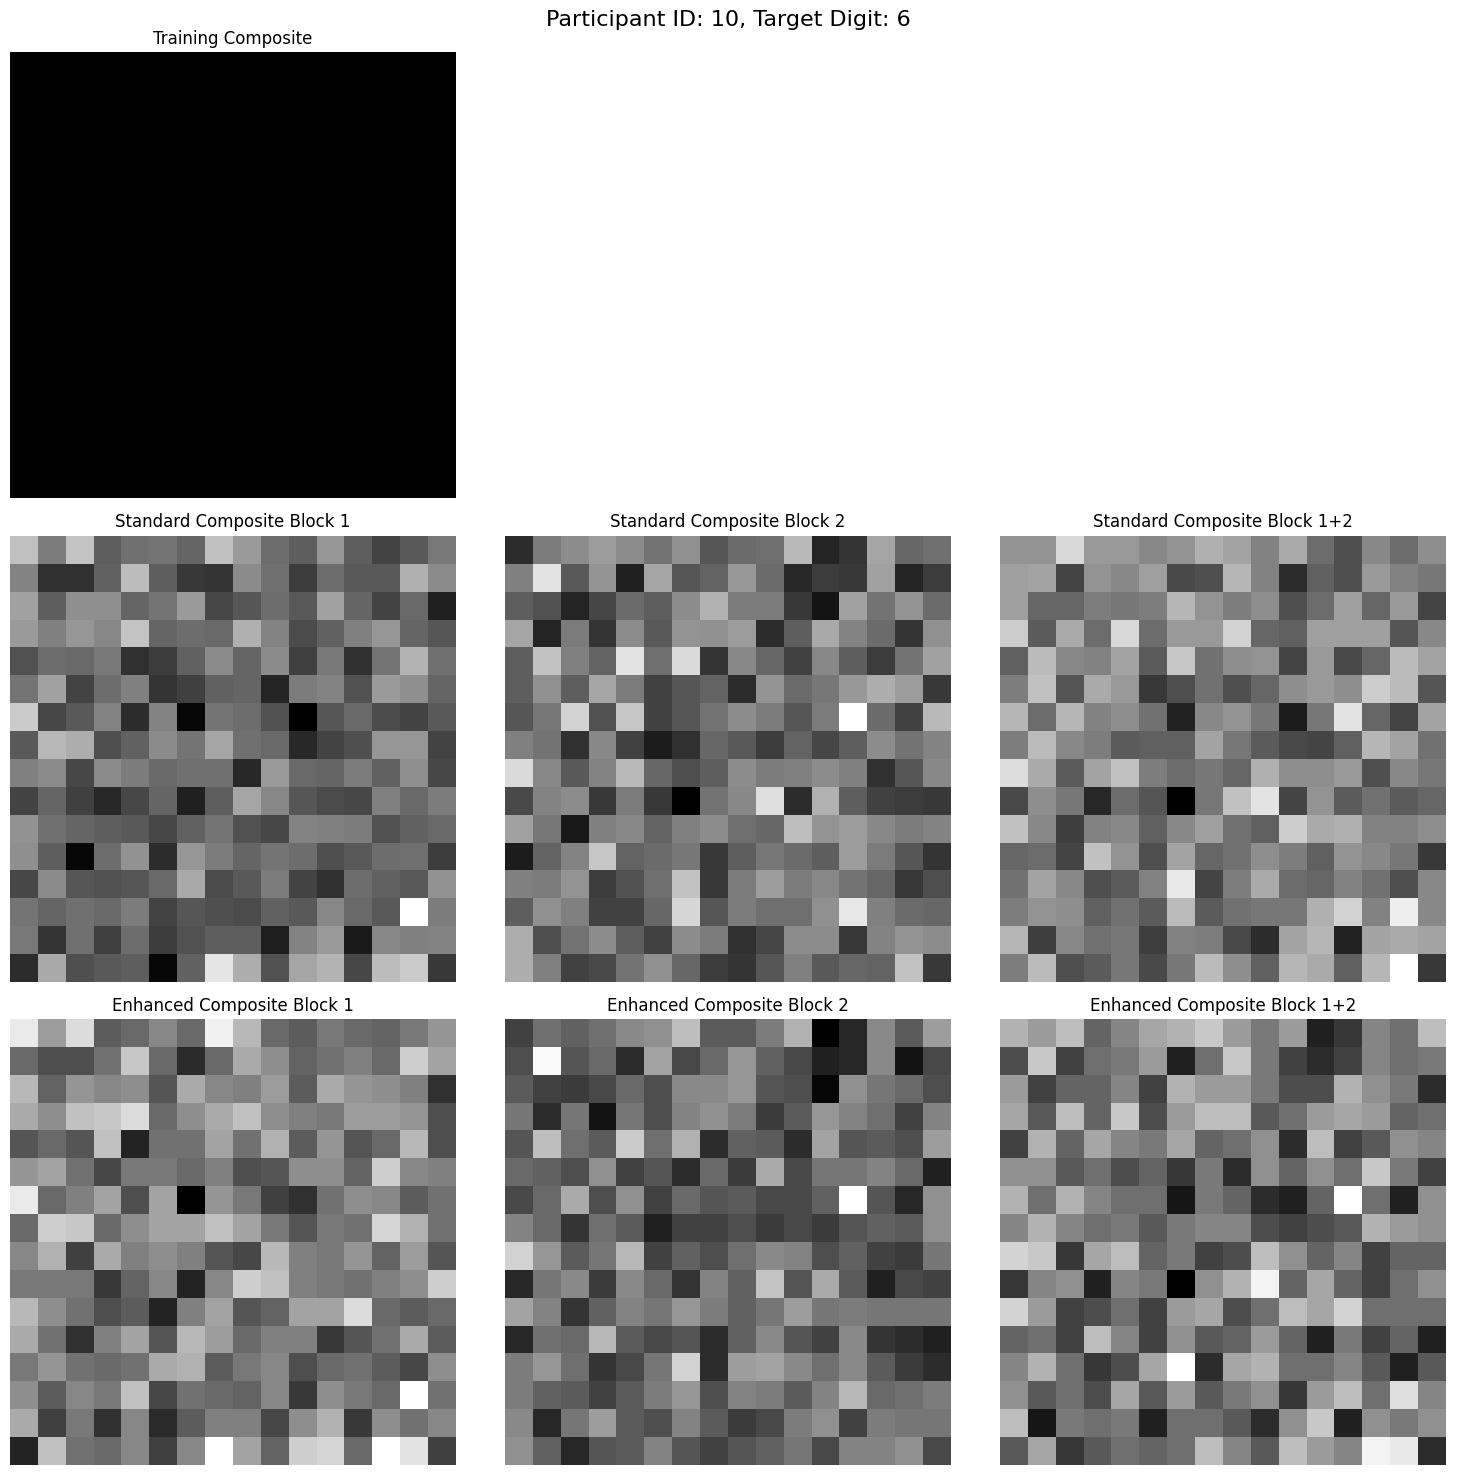

Processing participant d


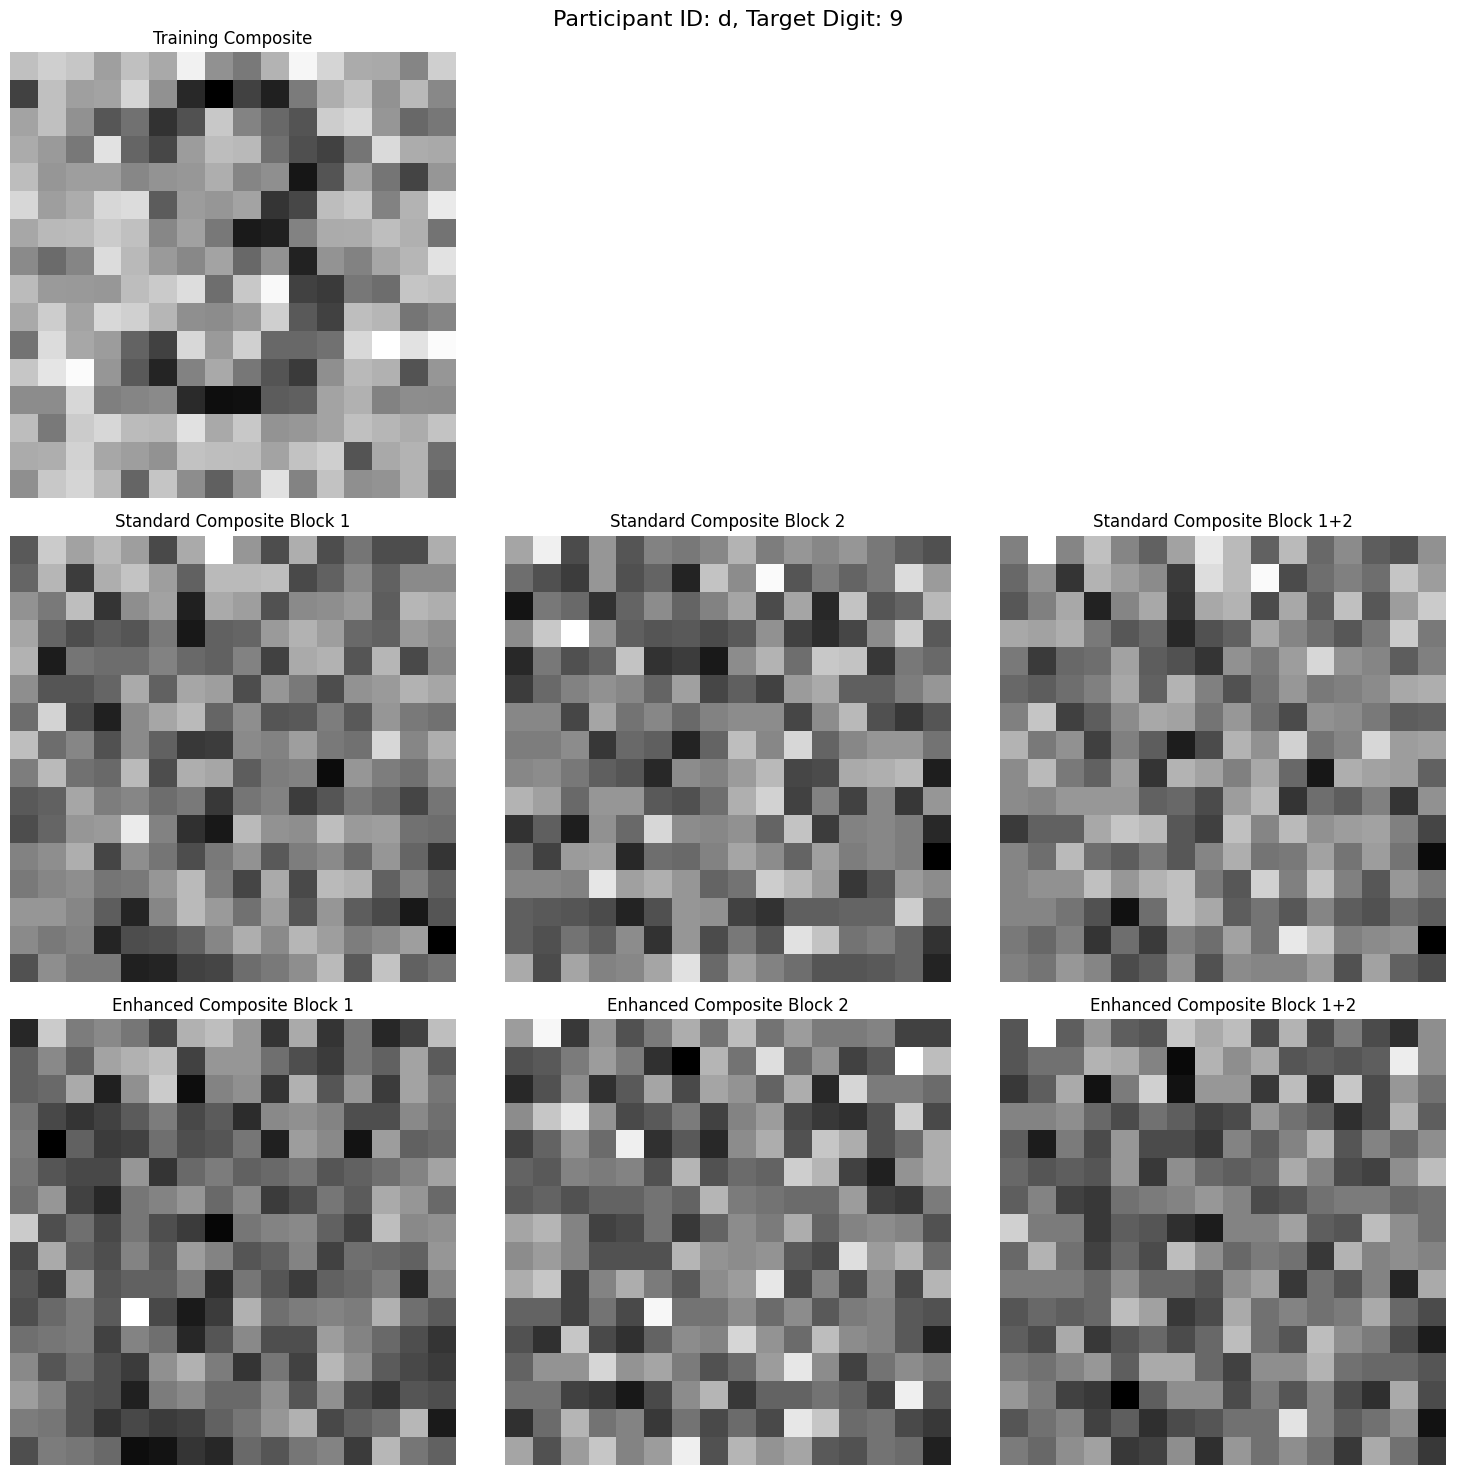

Processing participant 88755


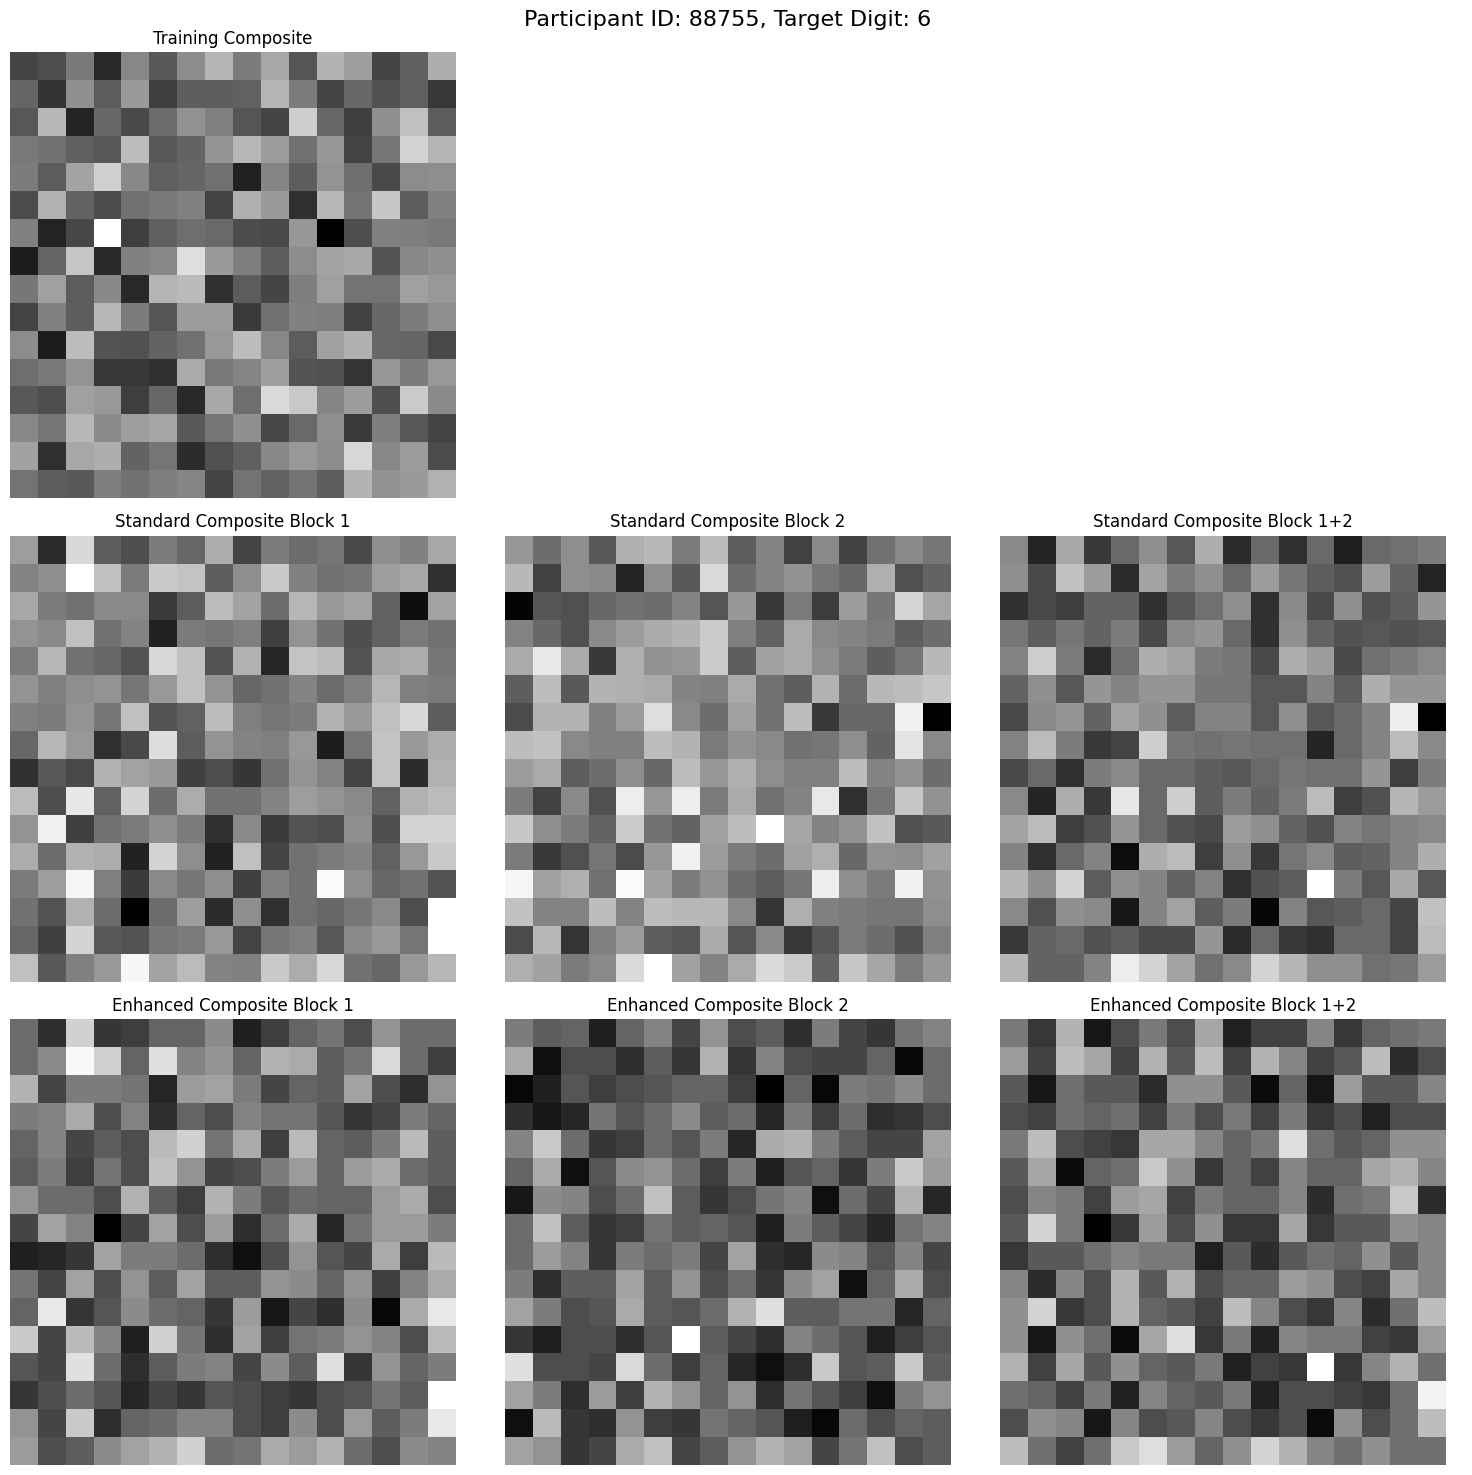

Processing participant 275555


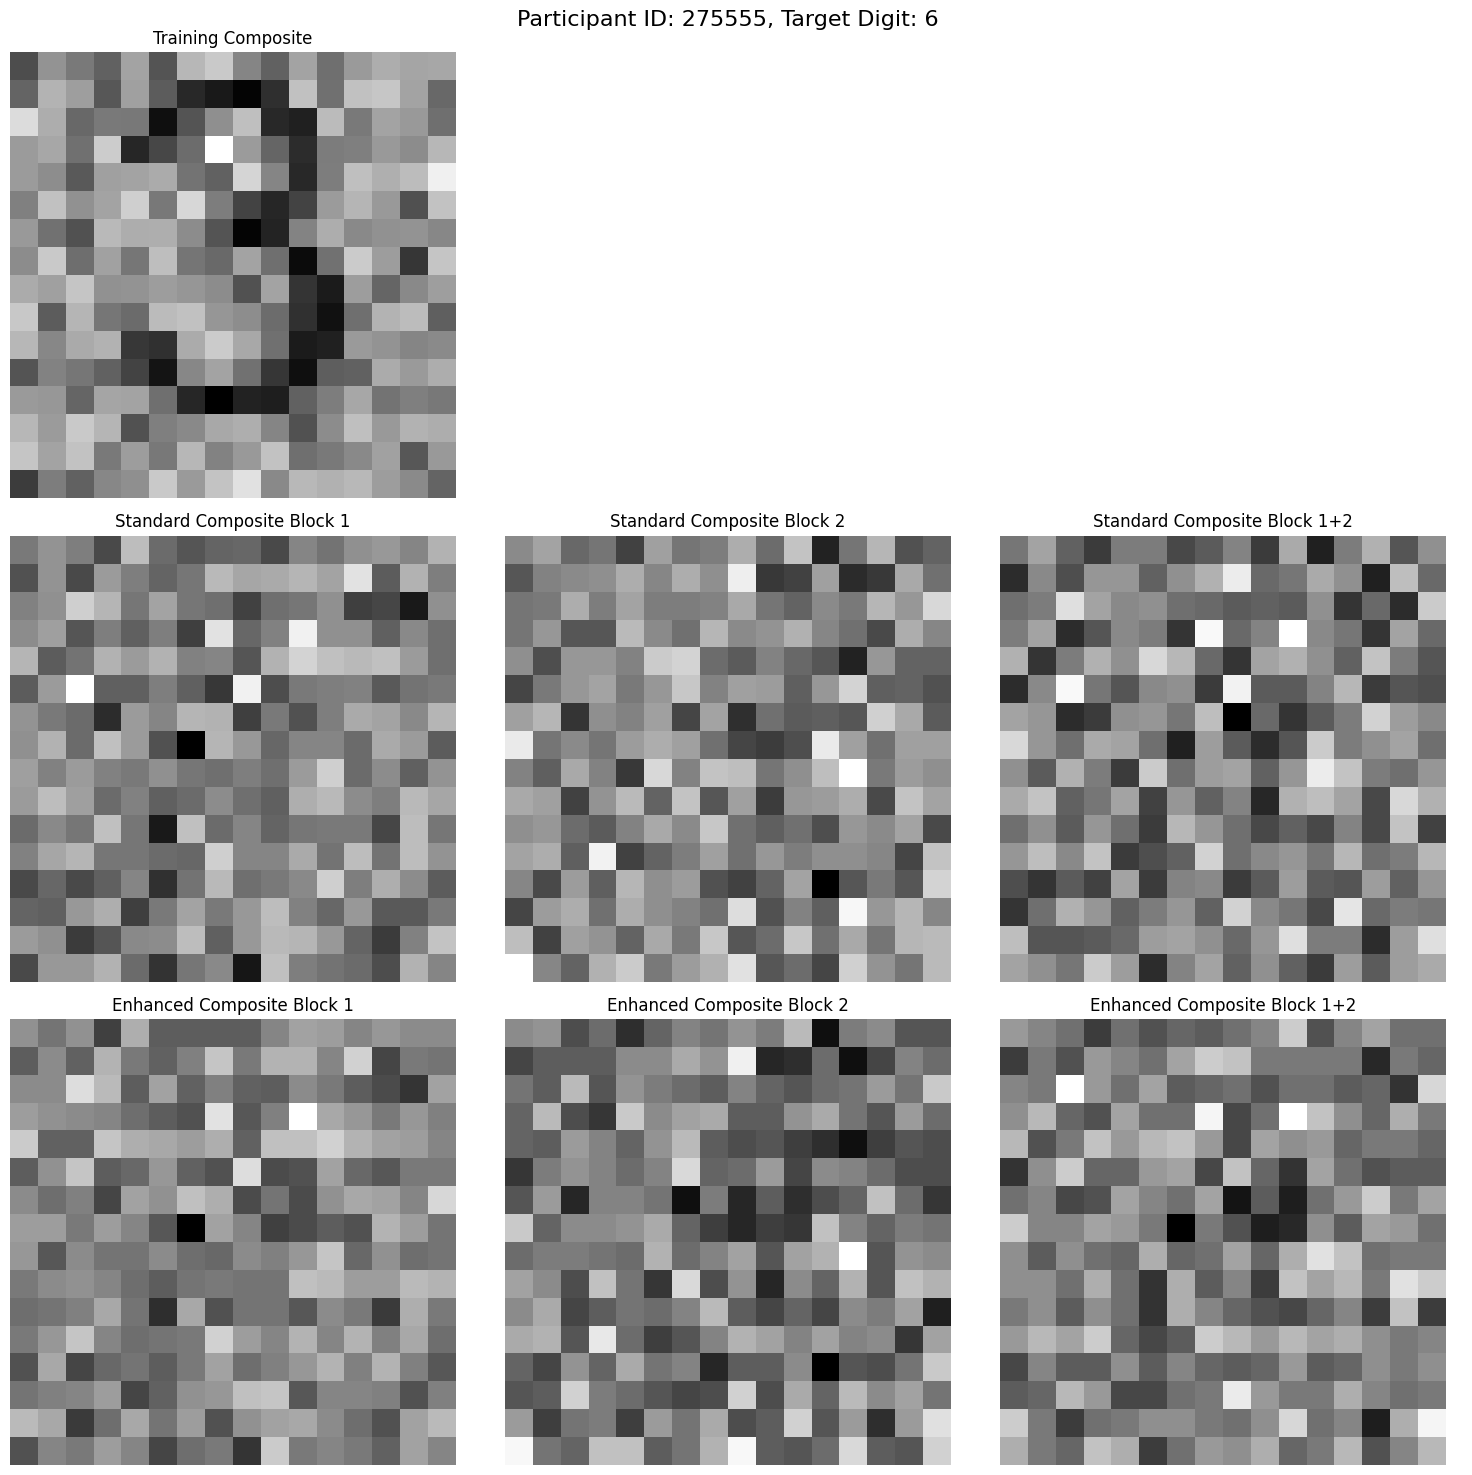

Processing participant tyl2g22


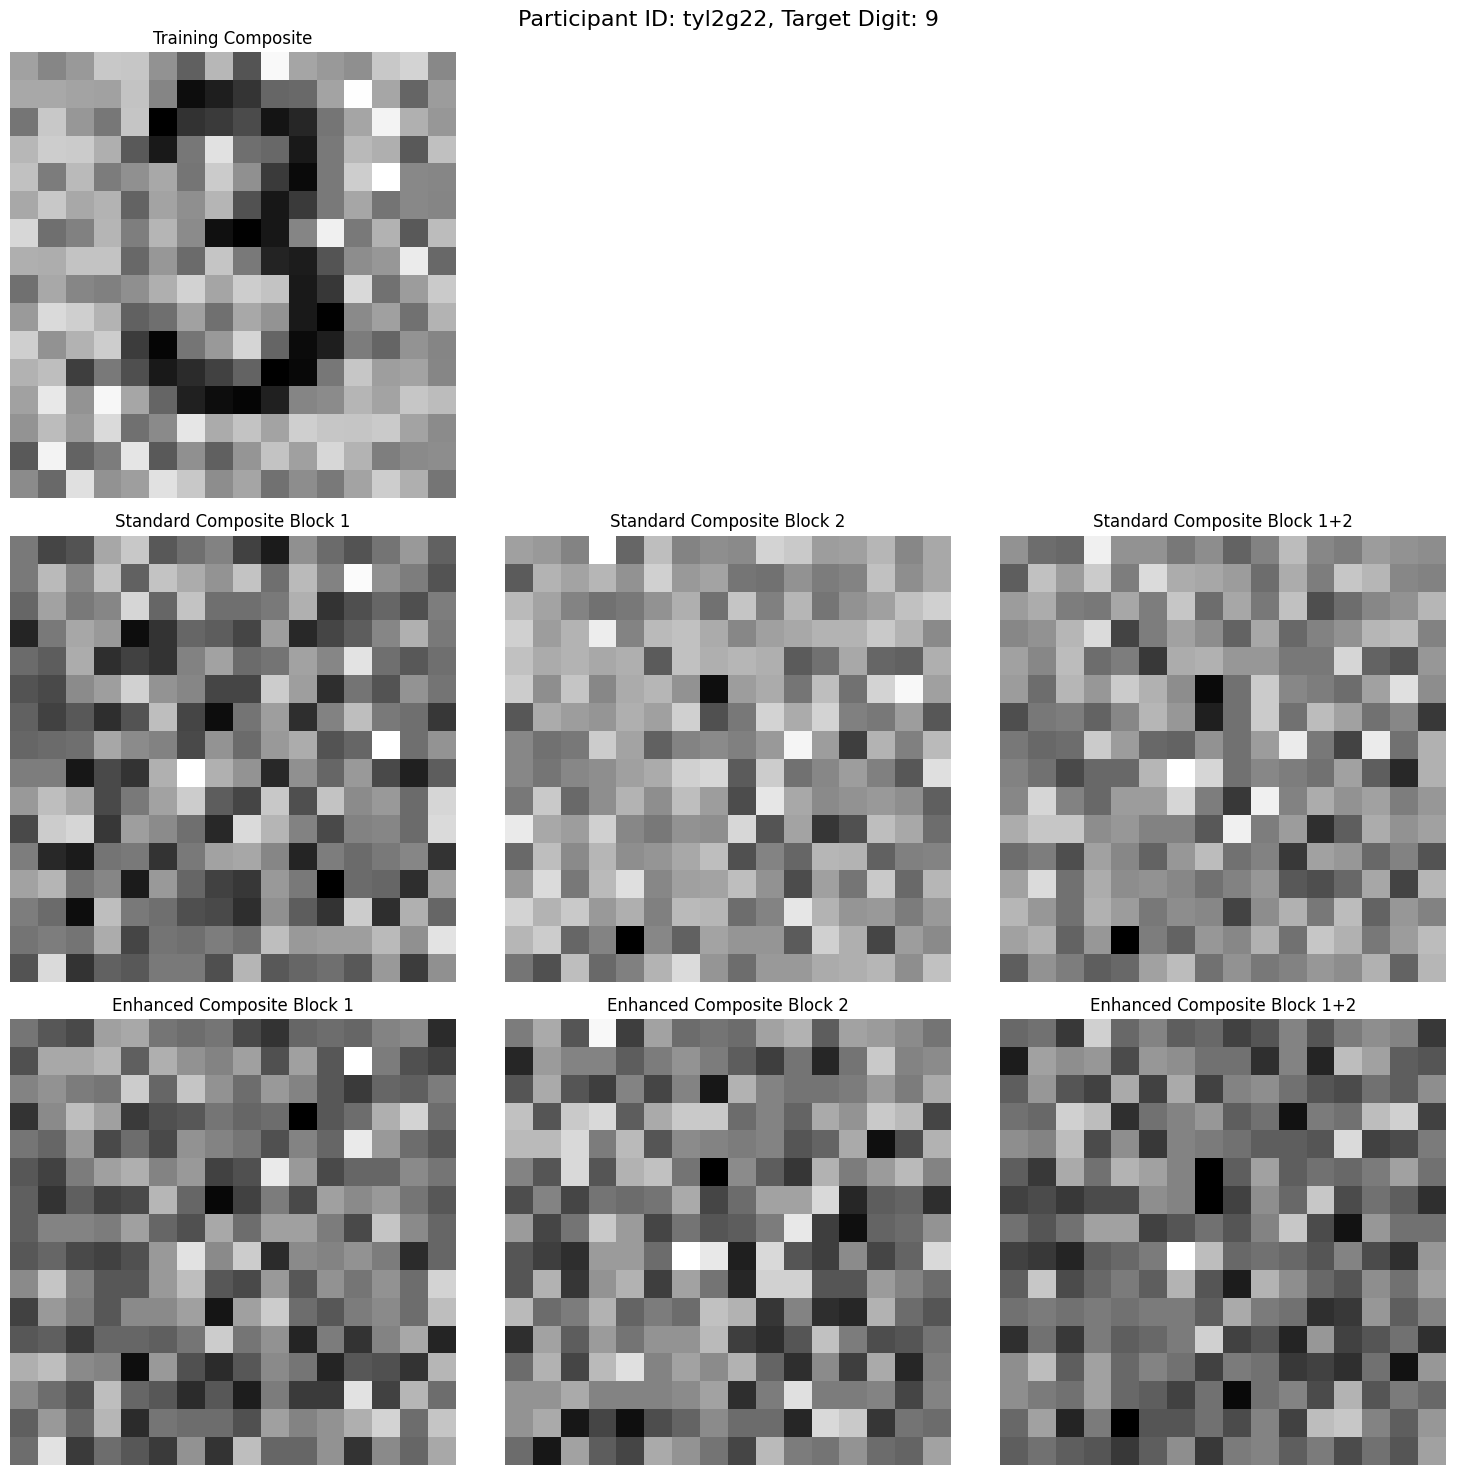

Processing participant ab8n22


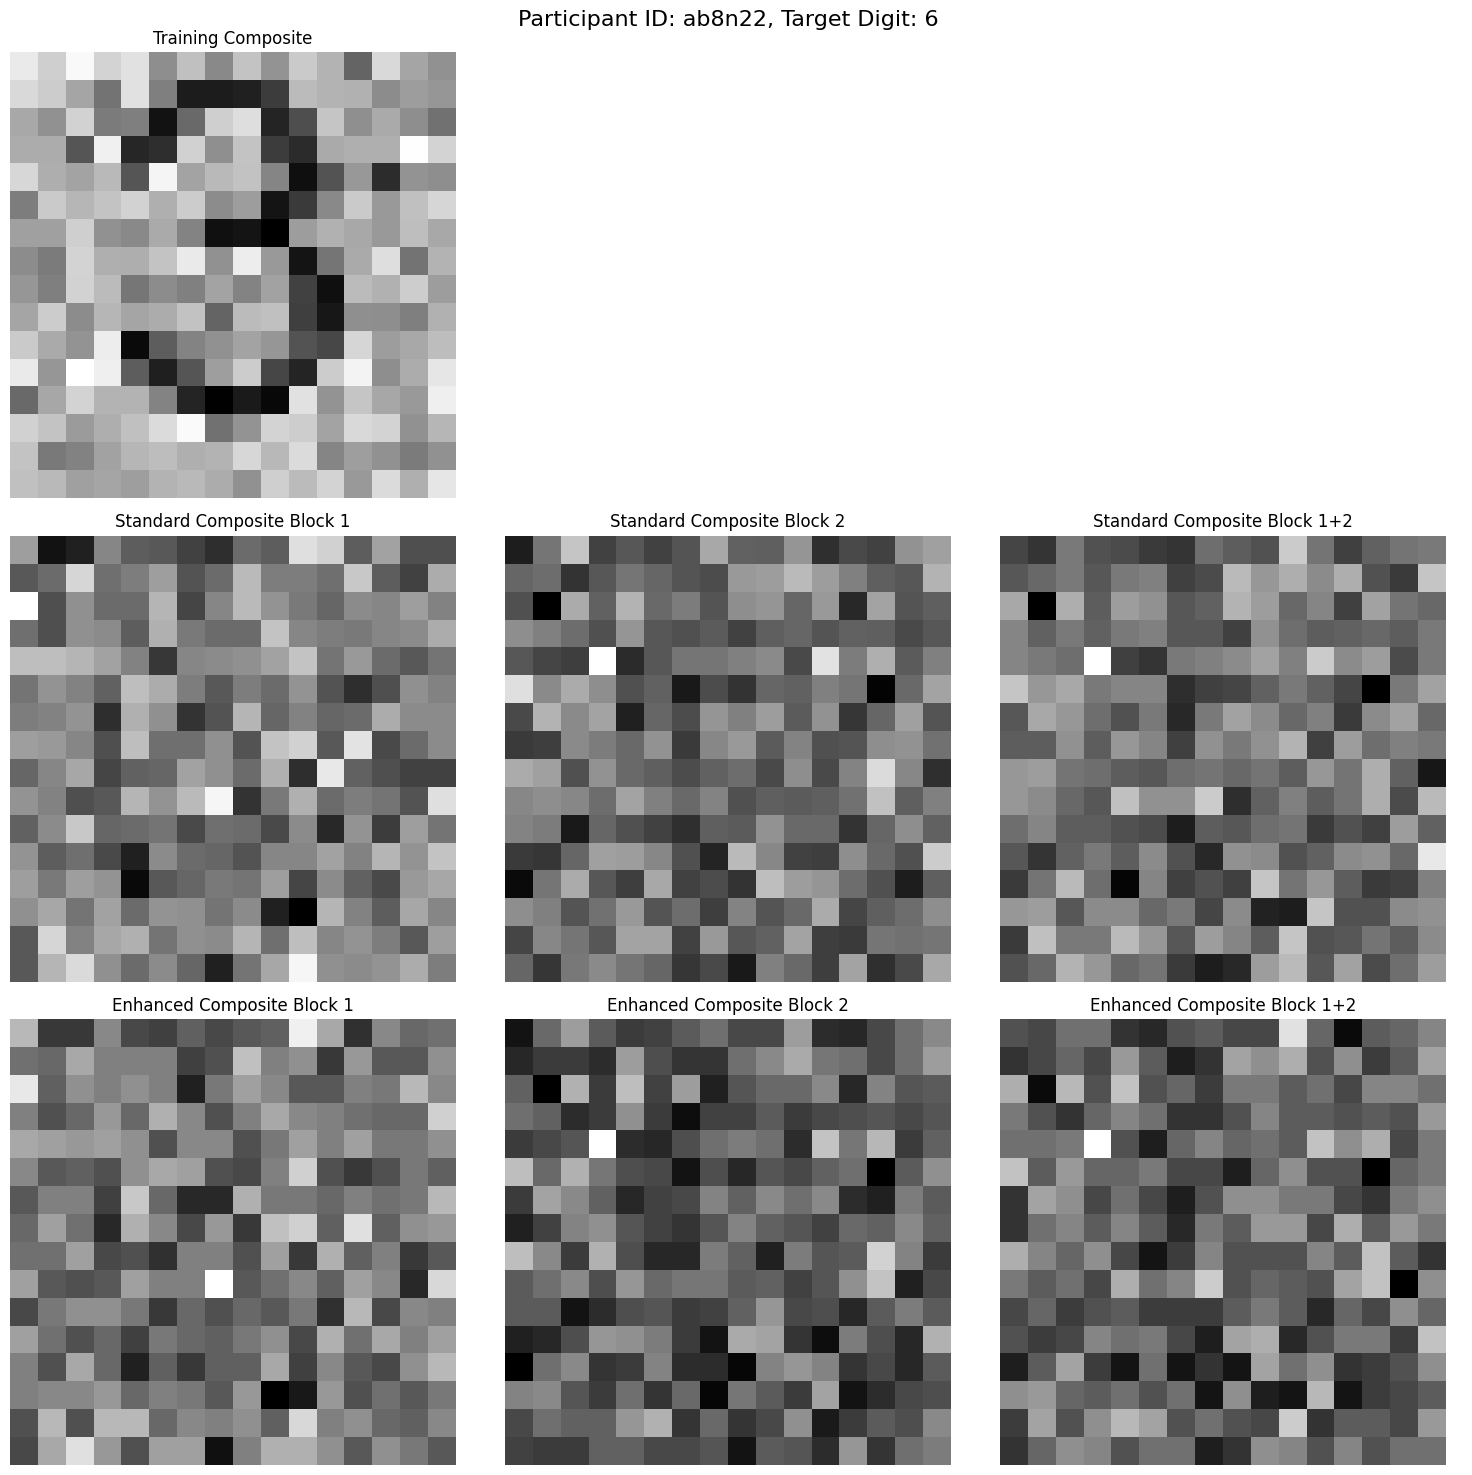

Processing participant 110424


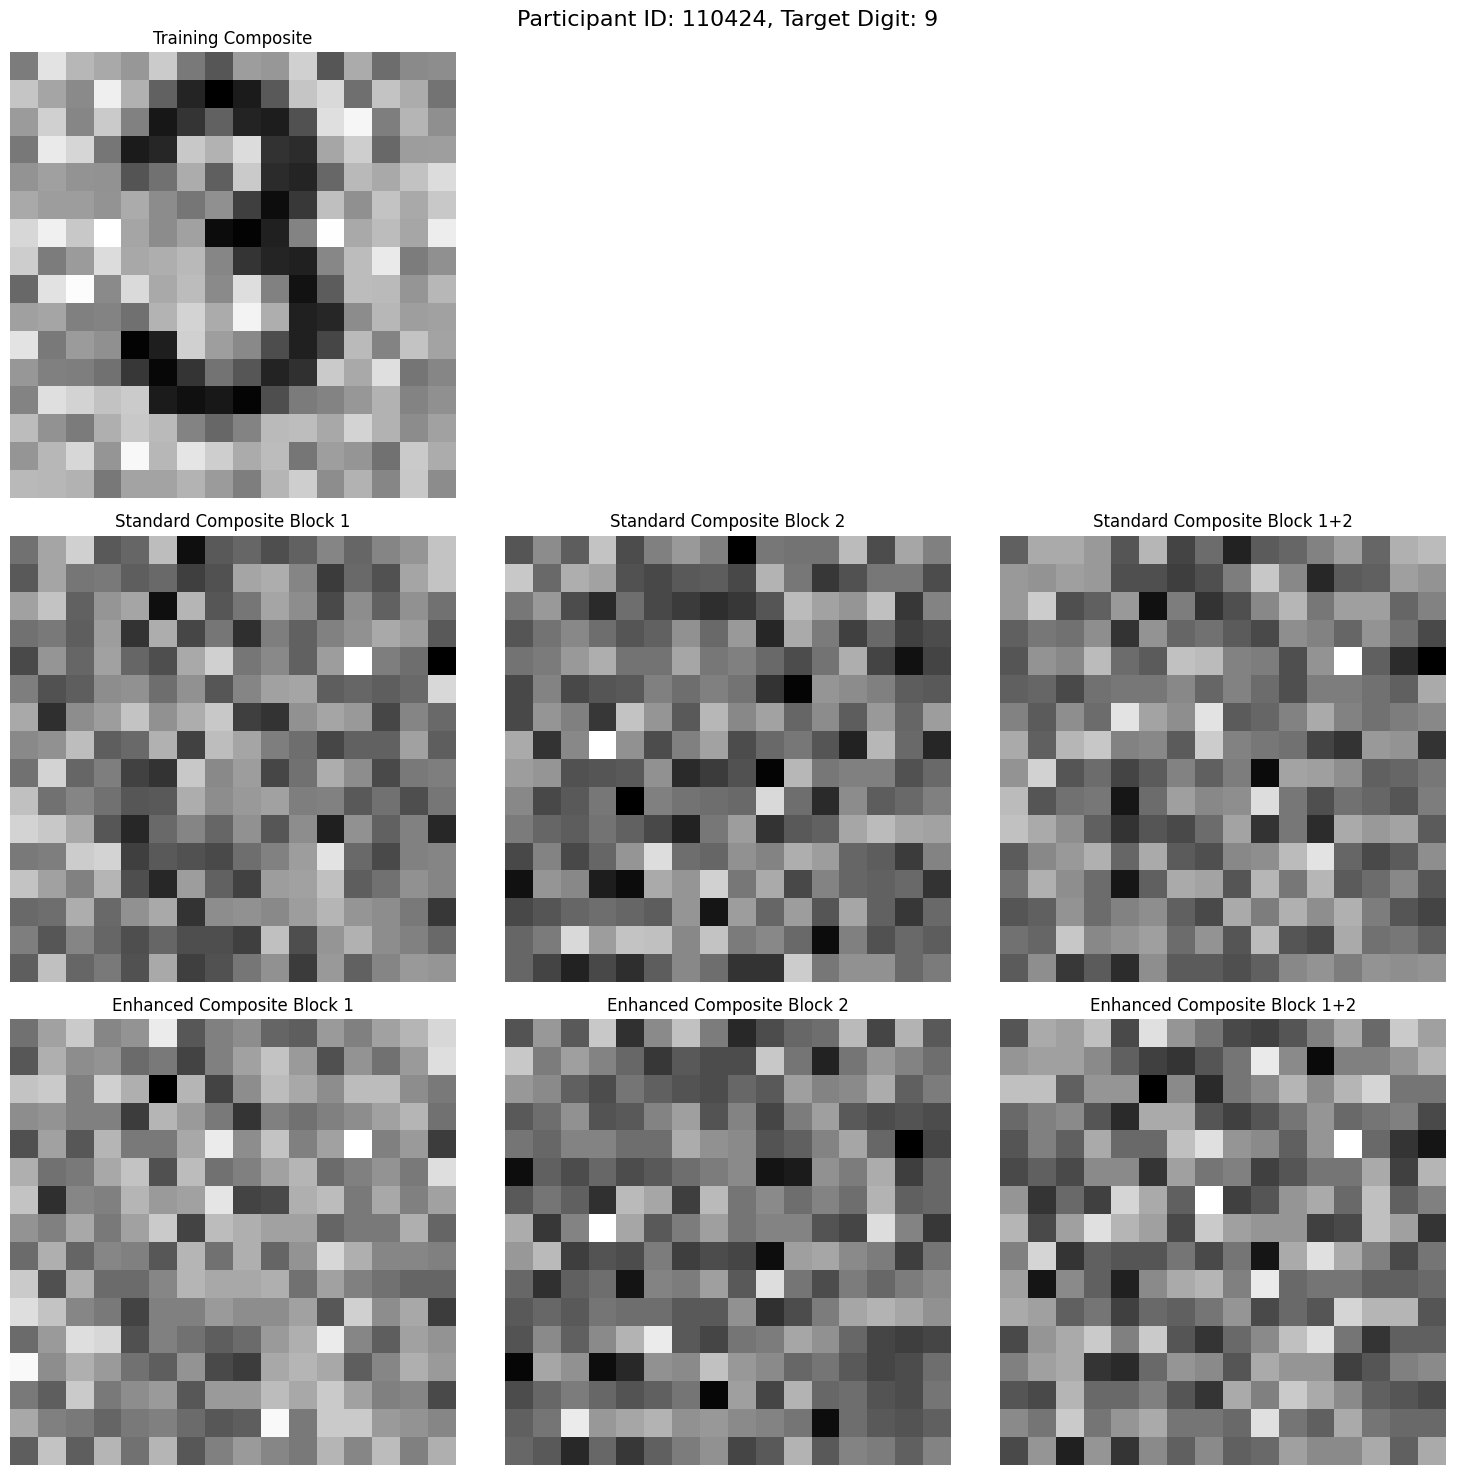

Processing participant jl18g24


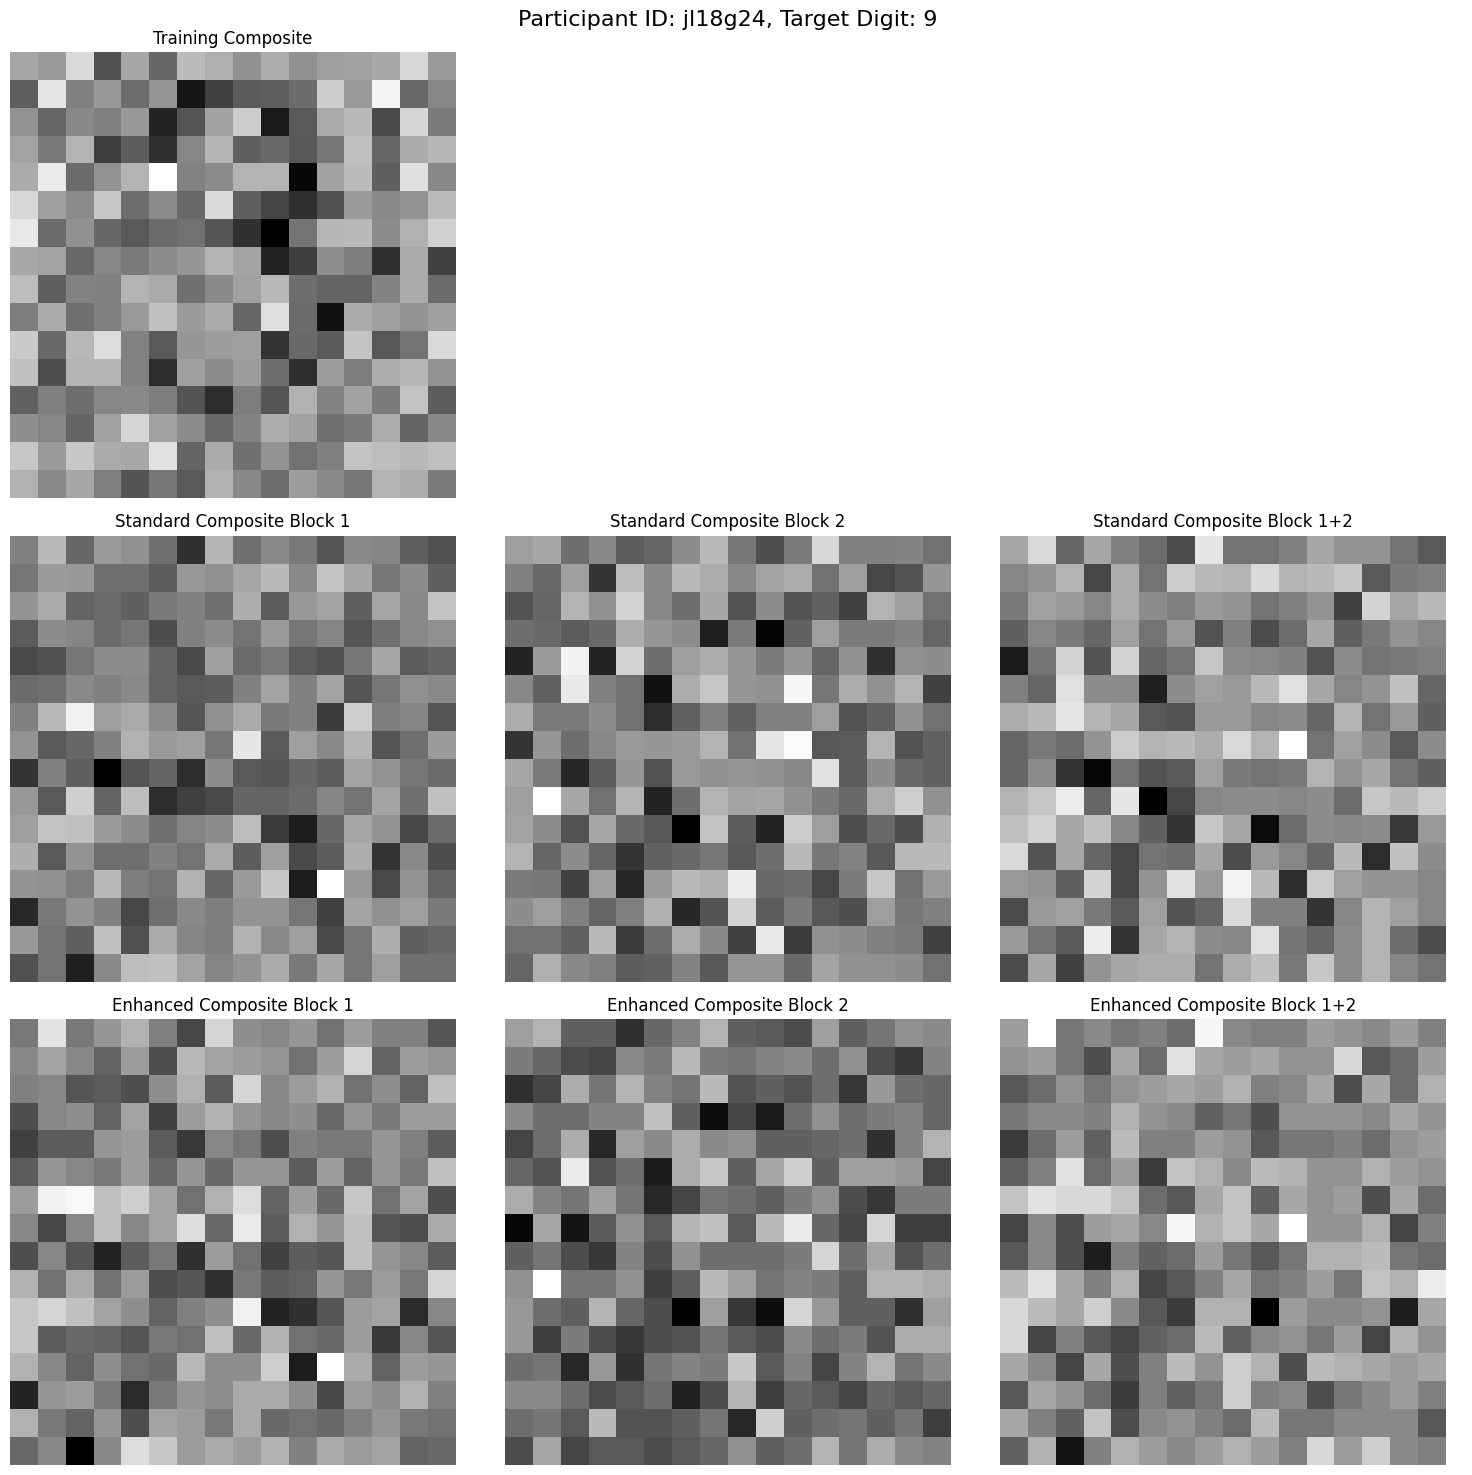

Processing participant 00000


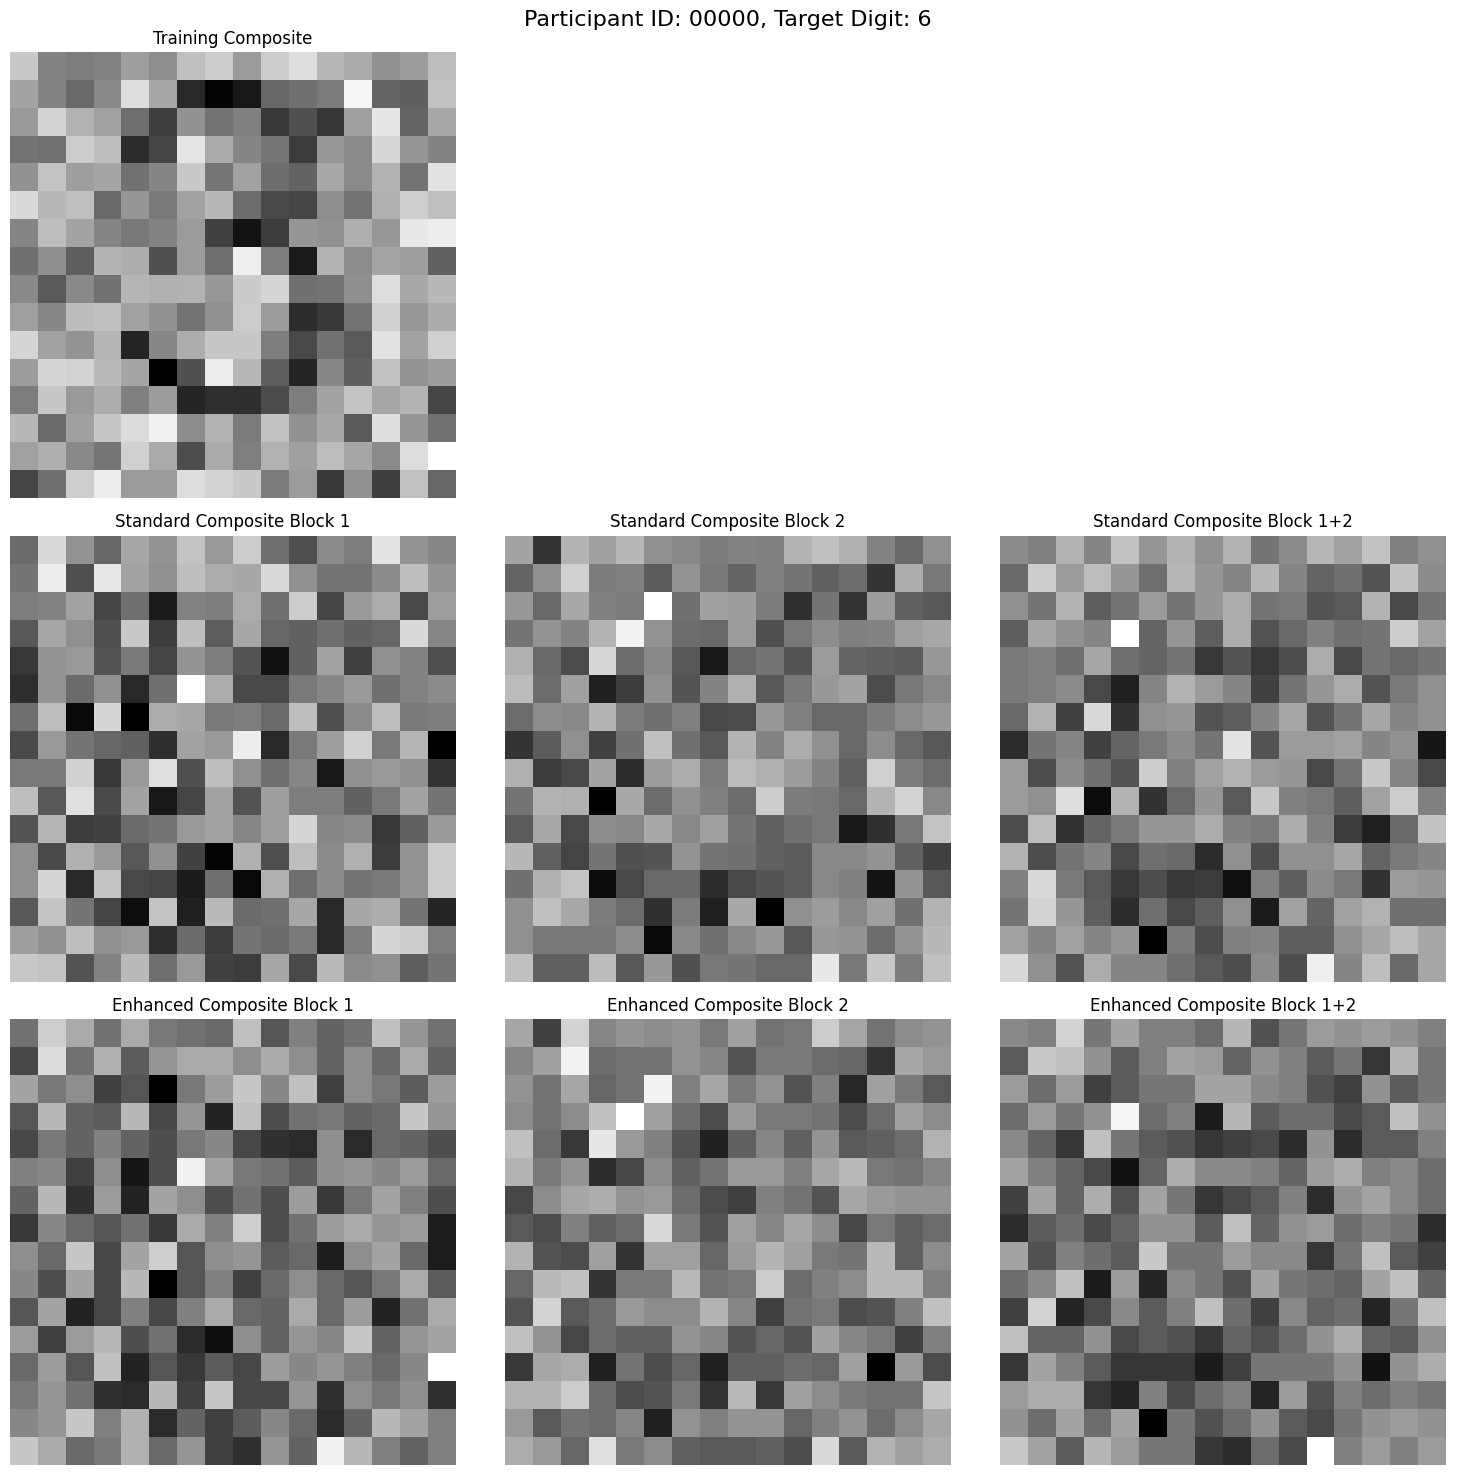

In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

def create_enhanced_composite(selected_images, non_selected_images):
    enhanced_trials = []
    for selected, non_selected_set in zip(selected_images, non_selected_images):
        selected_array = np.array(selected.convert('L').resize((16, 16)))
        non_selected_arrays = [np.array(img.convert('L').resize((16, 16))) for img in non_selected_set]
        avg_non_selected = np.mean(non_selected_arrays, axis=0)
        enhanced_trial = selected_array.astype(np.int16) - avg_non_selected.astype(np.int16)
        enhanced_trials.append(np.clip(enhanced_trial, 0, 255).astype(np.uint8))
    return np.mean(enhanced_trials, axis=0).astype(np.uint8)

def analyze_participant(participant_data):
    # Create training composite
    training_composite = create_composite_image(participant_data['training_images'])
    
    # Create standard composites
    standard_composites = {}
    enhanced_composites = {}
    
    for block in [1, 2]:
        selected = participant_data['selected_images'][block]
        non_selected = participant_data['non_selected_images'][block]
        
        # Standard composite
        standard_composites[block] = create_composite_image(selected)
        
        # Enhanced composite
        non_selected_reshaped = [non_selected[i:i+9] for i in range(0, len(non_selected), 9)]
        enhanced_composites[block] = create_enhanced_composite(selected, non_selected_reshaped)
    
    # Create block 1+2 composites
    all_selected = participant_data['selected_images'][1] + participant_data['selected_images'][2]
    all_non_selected = participant_data['non_selected_images'][1] + participant_data['non_selected_images'][2]
    
    standard_composites['1+2'] = create_composite_image(all_selected)
    
    all_non_selected_reshaped = [all_non_selected[i:i+9] for i in range(0, len(all_non_selected), 9)]
    enhanced_composites['1+2'] = create_enhanced_composite(all_selected, all_non_selected_reshaped)
    
    return {
        'training_composite': training_composite,
        'standard_composites': standard_composites,
        'enhanced_composites': enhanced_composites,
        'target_digit': participant_data['main_condition']
    }

def display_results(participant_id, results):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f"Participant ID: {participant_id}, Target Digit: {results['target_digit']}", fontsize=16)
    
    axes[0, 0].imshow(results['training_composite'], cmap='gray')
    axes[0, 0].set_title('Training Composite')
    
    for i, block in enumerate([1, 2, '1+2']):
        axes[1, i].imshow(results['standard_composites'][block], cmap='gray')
        axes[1, i].set_title(f'Standard Composite Block {block}')
        
        axes[2, i].imshow(results['enhanced_composites'][block], cmap='gray')
        axes[2, i].set_title(f'Enhanced Composite Block {block}')
    
    for ax in axes.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
# Main execution
for participant_id, data in all_participants_data.items():
    try:
        print(f"Processing participant {participant_id}")
        results = analyze_participant(data)
        display_results(participant_id, results)
    except Exception as e:
        print(f"Error processing participant {participant_id}: {str(e)}")
        print(f"Available keys for participant {participant_id}: {data.keys()}")
        # Print more detailed information about the data structure
        for key in data.keys():
            if isinstance(data[key], dict):
                print(f"{key}: {data[key].keys()}")
            elif isinstance(data[key], list):
                print(f"{key}: List of length {len(data[key])}")
            else:
                print(f"{key}: {type(data[key])}")

### Standard Composites

1. **For each block (1 and 2):**
   - We take all the selected images for that block.
   - We use the `create_composite_image` function, which does the following:
     a. Converts each image to grayscale and resizes it to 16x16 pixels.
     b. Converts each image to a numpy array.
     c. Stacks all these arrays.
     d. Calculates the mean across all images (pixel by pixel).
     e. Converts the result back to an 8-bit unsigned integer array.

2. **For the combined block 1+2:**
   - We concatenate the selected images from block 1 and block 2.
   - We then apply the same process as above to this combined list of images.

The standard composite is essentially an average of all selected images, representing the "typical" image chosen by the participant.

### Enhanced Composites

1. **For each block (1 and 2):**
   - We take all the selected images and all the non-selected images for that block.
   - We reshape the non-selected images into groups of 9 (as there should be 9 non-selected images for each selected image).
   - We then use the `create_enhanced_composite` function, which does the following for each trial:
     a. Convert the selected image to a 16x16 grayscale numpy array.
     b. Convert each of the 9 non-selected images to 16x16 grayscale numpy arrays.
     c. Calculate the average of the 9 non-selected images.
     d. Subtract this average non-selected image from the selected image.
     e. Clip the result to ensure values are between 0 and 255.
   - After processing all trials, we average all these enhanced trial images.

2. **For the combined block 1+2:**
   - We concatenate the selected images and non-selected images from both blocks.
   - We then apply the same process as above to this combined data.

The enhanced composite emphasizes the unique features of the selected images by subtracting out the "background noise" represented by the non-selected images. This process should theoretically highlight the key features that the participant is using to make their selections.

### Logical Soundness

This approach is logically sound because:

1. **Standard Composites:** By averaging all selected images, we get a representation of the "typical" image that the participant chose. This helps visualize any consistent patterns in their selections.

2. **Enhanced Composites:** By subtracting the average of non-selected images from each selected image, we're essentially removing the common features present in all images and highlighting what's unique about the selected images. This process is done on a trial-by-trial basis before averaging, which should preserve trial-specific enhancements.

3. **Block 1+2 Composites:** By combining data from both blocks, we get an overall representation of the participant's choices across the entire experiment, which can reveal more stable patterns.

4. **Image Processing:** All images are consistently processed (grayscale, 16x16 resize) to ensure comparability.

5. **Averaging:** The use of averaging helps to reduce noise and emphasize consistent patterns across trials and blocks.

This approach should provide a good visualization of the patterns in the participant's image selections, both in terms of what they typically chose (standard composites) and what unique features guided their choices (enhanced composites).

let's look at some basic correlations

Correlations:
                           vviq_absolute_score_total  caps_total_score  \
vviq_absolute_score_total                   1.000000         -0.421841   
caps_total_score                           -0.421841          1.000000   
caps_visual_score                          -0.300733          0.646170   
training_accuracy                           0.448452          0.335847   

                           caps_visual_score  training_accuracy  
vviq_absolute_score_total          -0.300733           0.448452  
caps_total_score                    0.646170           0.335847  
caps_visual_score                   1.000000           0.064550  
training_accuracy                   0.064550           1.000000  

P-values:
                          vviq_absolute_score_total caps_total_score  \
vviq_absolute_score_total                       NaN         0.258084   
caps_total_score                           0.258084              NaN   
caps_visual_score                          0.431666       

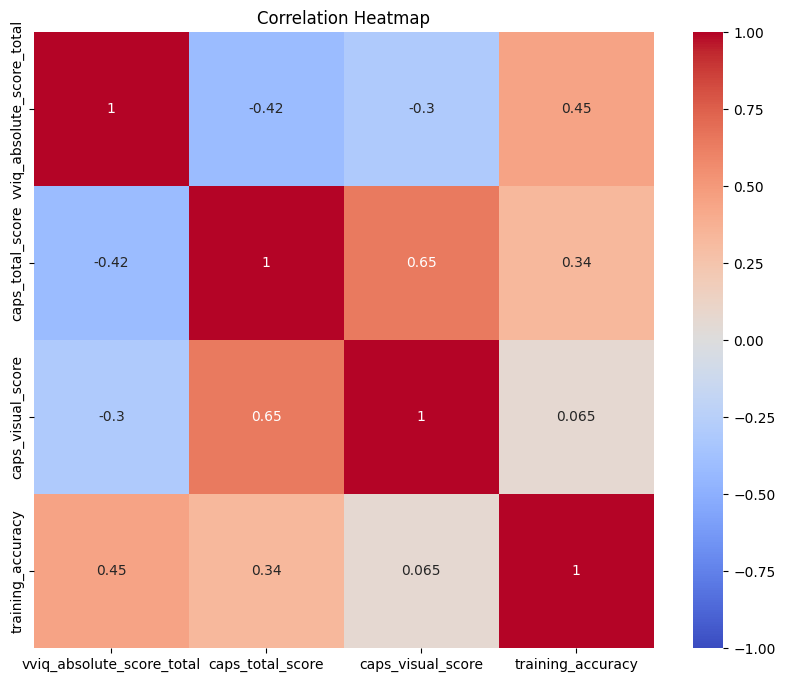


Specific Correlations of Interest:
VVIQ vs Overall CAPS:
  Correlation coefficient: -0.4218
  p-value: 0.2581

VVIQ vs Visual CAPS:
  Correlation coefficient: -0.3007
  p-value: 0.4317

VVIQ vs Training Accuracy:
  Correlation coefficient: 0.4485
  p-value: 0.2260

Overall CAPS vs Training Accuracy:
  Correlation coefficient: 0.3358
  p-value: 0.3769



In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def analyze_correlations(summary_df):
    # Define the variables we want to correlate
    variables = ['vviq_absolute_score_total', 'caps_total_score', 'caps_visual_score', 'training_accuracy']
    
    # Create a correlation matrix
    corr_matrix = summary_df[variables].corr()
    
    # Calculate p-values
    p_values = pd.DataFrame(columns=variables, index=variables)
    for i in variables:
        for j in variables:
            if i != j:
                _, p = stats.pearsonr(summary_df[i], summary_df[j])
                p_values.loc[i, j] = p
    
    # Print correlations and p-values
    print("Correlations:")
    print(corr_matrix)
    print("\nP-values:")
    print(p_values)
    
    # Create a heatmap of correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Specific correlations of interest
    correlations_of_interest = [
        ('VVIQ', 'Overall CAPS', 'vviq_absolute_score_total', 'caps_total_score'),
        ('VVIQ', 'Visual CAPS', 'vviq_absolute_score_total', 'caps_visual_score'),
        ('VVIQ', 'Training Accuracy', 'vviq_absolute_score_total', 'training_accuracy'),
        ('Overall CAPS', 'Training Accuracy', 'caps_total_score', 'training_accuracy')
    ]
    
    print("\nSpecific Correlations of Interest:")
    for corr in correlations_of_interest:
        r, p = stats.pearsonr(summary_df[corr[2]], summary_df[corr[3]])
        print(f"{corr[0]} vs {corr[1]}:")
        print(f"  Correlation coefficient: {r:.4f}")
        print(f"  p-value: {p:.4f}")
        print()

# Usage:
# Assuming you have already created your summary_df
analyze_correlations(summary_df)

Now let's look at some classifications

In [13]:
class ModelEnsemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, x):
        predictions = [model(x) for model in self.models]
        return torch.stack(predictions).mean(dim=0)
    
    def eval(self):
        for model in self.models:
            model.eval()

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import string

def load_ensemble_models(model_class, folder_path, num_models=20, device='cpu', verbose=True):
    models = []
    
    for idx, letter in enumerate(string.ascii_lowercase[:num_models]):
        model = model_class()
        checkpoint_path = os.path.join(folder_path, f'skeptic_v10_{letter}_finetuned.pth')
        
        try:
            if not os.path.exists(checkpoint_path):
                raise FileNotFoundError(f"Model checkpoint not found: {checkpoint_path}")
            
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            models.append(model)
            
            if verbose:
                print(f"Loaded model {idx+1}/{num_models}: {checkpoint_path}")
        except Exception as e:
            print(f"Error loading model {idx+1}/{num_models}: {str(e)}")
    
    if not models:
        raise ValueError("No models were successfully loaded.")
    
    ensemble = ModelEnsemble(models)
    ensemble.eval()
    return ensemble

def get_model_predictions(ensemble, image):
    # Convert image to grayscale
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'), 'L')
    elif image.mode != 'L':
        image = image.convert('L')
    
    # Define the transformation for the input image
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)
    
    # Move tensor to the same device as the models
    device = next(ensemble.models[0].parameters()).device
    image_tensor = image_tensor.to(device)
    
    # Get predictions from the ensemble model
    ensemble.eval()
    with torch.no_grad():
        predictions = ensemble.predict(image_tensor)
    
    return predictions.cpu().numpy()[0]

def classify_composites(ensemble, all_participants_data):
    results = {}

    for participant_id, data in all_participants_data.items():
        print(f"Processing participant {participant_id}...")
        # Analyze participant to get composites
        analysis_results = analyze_participant(data)

        # Prepare a dictionary for predictions
        predictions = {
            'training_composite': None,
            'standard_composites': {},
            'enhanced_composites': {}
        }

        # Classify training composite
        predictions['training_composite'] = get_model_predictions(ensemble, analysis_results['training_composite'])

        # Classify standard and enhanced composites for each block
        for block in [1, 2, '1+2']:
            predictions['standard_composites'][block] = get_model_predictions(ensemble, analysis_results['standard_composites'][block])
            predictions['enhanced_composites'][block] = get_model_predictions(ensemble, analysis_results['enhanced_composites'][block])

        # Store results
        results[participant_id] = predictions

    return results

def analyze_classifications(classifications, all_participants_data):
    for participant_id, predictions in classifications.items():
        print(f"\nParticipant {participant_id}")
        target_digit = all_participants_data[participant_id]['main_condition']
        print(f"Target Digit: {target_digit}")

        # Analyze training composite
        print("\nTraining Composite:")
        analyze_prediction(predictions['training_composite'], target_digit)

        # Analyze standard and enhanced composites
        for composite_type in ['standard_composites', 'enhanced_composites']:
            print(f"\n{composite_type.replace('_', ' ').title()}:")
            for block in [1, 2, '1+2']:
                print(f"  Block {block}:")
                analyze_prediction(predictions[composite_type][block], target_digit)

def analyze_prediction(prediction, target_digit):
    predicted_digit = np.argmax(prediction)
    confidence = np.max(prediction)
    distance = min((predicted_digit - target_digit) % 10, (target_digit - predicted_digit) % 10)
    
    print(f"    Predicted digit: {predicted_digit}")
    print(f"    Confidence: {confidence:.4f}")
    print(f"    Distance from target: {distance}")
    print(f"    Confidence for target digit ({target_digit}): {prediction[target_digit]:.4f}")
    
    # Rank of the target digit
    sorted_indices = np.argsort(prediction)[::-1]
    target_rank = np.where(sorted_indices == target_digit)[0][0] + 1
    print(f"    Rank of target digit: {target_rank} out of 10")
    
    # Display ordered predictions
    print("    Ordered predictions:")
    for digit in sorted_indices:
        print(f"      Digit {digit}: {prediction[digit]:.4f}")

# Main execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    ensemble = load_ensemble_models(skeptic_v9, 'saved_models/skeptic_v10', num_models=20, device=device)
    print("Ensemble loaded successfully.")

    # Classify composites for all participants
    classifications = classify_composites(ensemble, all_participants_data)

    # Analyze and display results
    analyze_classifications(classifications, all_participants_data)

except Exception as e:
    print(f"Error during classification: {str(e)}")

C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2787803751.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


Loaded model 1/20: saved_models/skeptic_v10\skeptic_v10_a_finetuned.pth
Loaded model 2/20: saved_models/skeptic_v10\skeptic_v10_b_finetuned.pth
Loaded model 3/20: saved_models/skeptic_v10\skeptic_v10_c_finetuned.pth
Loaded model 4/20: saved_models/skeptic_v10\skeptic_v10_d_finetuned.pth
Loaded model 5/20: saved_models/skeptic_v10\skeptic_v10_e_finetuned.pth
Loaded model 6/20: saved_models/skeptic_v10\skeptic_v10_f_finetuned.pth
Loaded model 7/20: saved_models/skeptic_v10\skeptic_v10_g_finetuned.pth
Loaded model 8/20: saved_models/skeptic_v10\skeptic_v10_h_finetuned.pth
Loaded model 9/20: saved_models/skeptic_v10\skeptic_v10_i_finetuned.pth
Loaded model 10/20: saved_models/skeptic_v10\skeptic_v10_j_finetuned.pth
Loaded model 11/20: saved_models/skeptic_v10\skeptic_v10_k_finetuned.pth
Loaded model 12/20: saved_models/skeptic_v10\skeptic_v10_l_finetuned.pth
Loaded model 13/20: saved_models/skeptic_v10\skeptic_v10_m_finetuned.pth
Loaded model 14/20: saved_models/skeptic_v10\skeptic_v10_n_f

In [15]:
def calculate_test_retest(predictions, target_digit):
    # Prepare the arrays for correlations
    standard_b1 = predictions['standard_composites'][1]
    enhanced_b1 = predictions['enhanced_composites'][1]
    standard_b2 = predictions['standard_composites'][2]
    enhanced_b2 = predictions['enhanced_composites'][2]
    
    # Create arrays for use in correlation
    block1 = np.array([standard_b1, enhanced_b1]).flatten()
    block2 = np.array([standard_b2, enhanced_b2]).flatten()
    
    # Calculate the correlation coefficient
    corr_matrix = np.corrcoef(block1, block2)
    corr = corr_matrix[0, 1]  # Take the off-diagonal value
    return corr

In [16]:
def get_target_rank(predictions, target_digit):
    sorted_indices = np.argsort(predictions)[::-1]  # Sort in descending order
    return np.where(sorted_indices == target_digit)[0][0] + 1  # Add 1 because ranks start at 1, not 0

from IPython.display import display, HTML


Participant 10 - Main Target Digit: 6



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,8,0.1528,-0.1891,8,nan,nan,5
1,Standard Composites,1,6,1,0.2841,-0.0996,7,0.9962,1.0000,5
2,Standard Composites,2,6,1,0.2738,-0.1031,7,0.9962,1.0000,5
3,Standard Composites,1+2,6,1,0.2692,-0.0949,7,nan,nan,5
4,Enhanced Composites,1,6,9,0.0304,0.0270,3,0.9962,1.0000,3
5,Enhanced Composites,2,6,8,0.0306,0.0210,3,0.9962,1.0000,2
6,Enhanced Composites,1+2,6,9,0.0289,0.0248,3,nan,nan,3



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: -1.0000
Digit 1: -1.0000
Digit 2: 1.0000
Digit 3: -1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: -1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: 1.0000
Digit 9: -1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


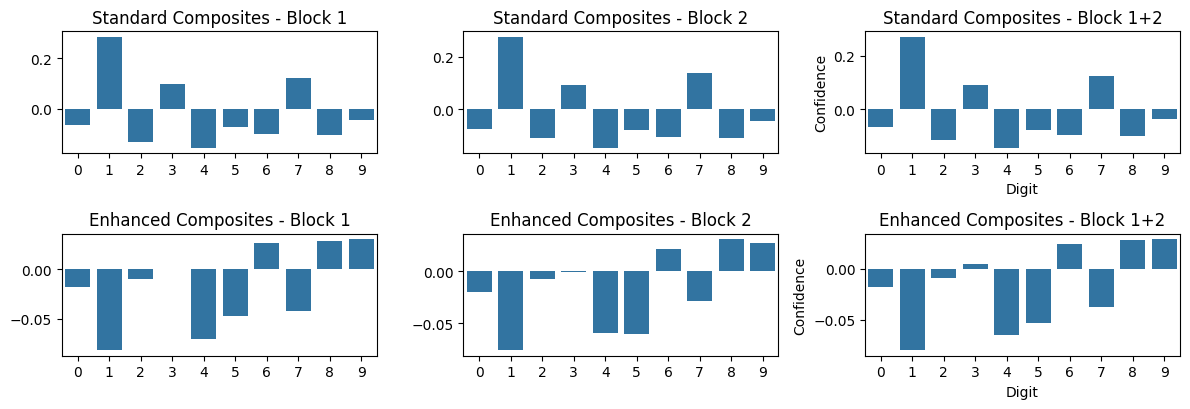


Participant d - Main Target Digit: 9



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.2574,0.1483,2,nan,nan,2
1,Standard Composites,1,9,1,0.2965,-0.0478,4,0.9923,1.0000,2
2,Standard Composites,2,9,1,0.2783,-0.0603,4,0.9923,1.0000,2
3,Standard Composites,1+2,9,1,0.2841,-0.0471,4,nan,nan,2
4,Enhanced Composites,1,9,8,0.0239,0.0151,3,0.9923,1.0000,1
5,Enhanced Composites,2,9,6,0.0331,0.0209,3,0.9923,1.0000,3
6,Enhanced Composites,1+2,9,6,0.0296,0.0171,3,nan,nan,3



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: -1.0000
Digit 1: -1.0000
Digit 2: -1.0000
Digit 3: -1.0000
Digit 4: -1.0000
Digit 5: 1.0000
Digit 6: 1.0000
Digit 7: -1.0000
Digit 8: 1.0000
Digit 9: -1.0000

Enhanced Composites:
Digit 0: 1.0000
Digit 1: -1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: -1.0000
Digit 5: 1.0000
Digit 6: 1.0000
Digit 7: -1.0000
Digit 8: 1.0000
Digit 9: 1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


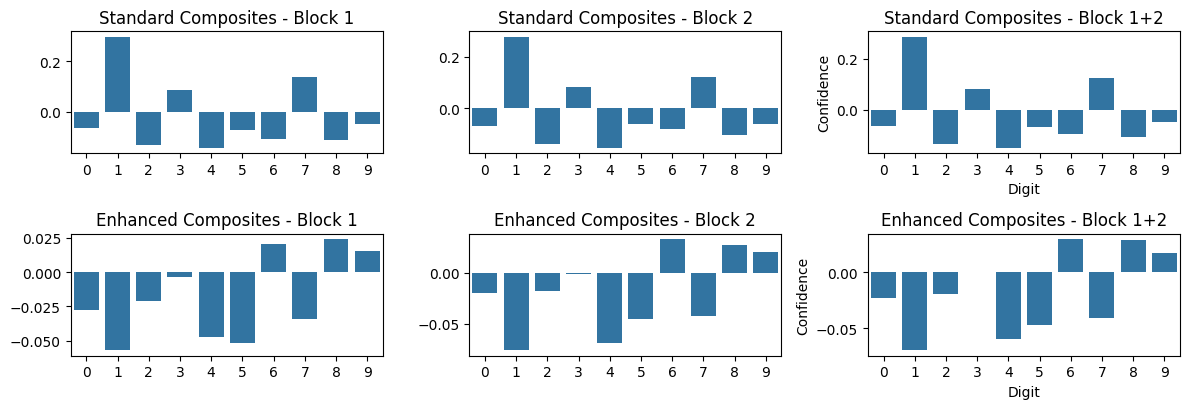


Participant 88755 - Main Target Digit: 6



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.3537,0.1318,3,nan,nan,2
1,Standard Composites,1,6,1,0.2817,-0.1053,7,0.9972,1.0000,5
2,Standard Composites,2,6,1,0.2880,-0.1045,7,0.9972,1.0000,5
3,Standard Composites,1+2,6,1,0.2806,-0.0997,7,nan,nan,5
4,Enhanced Composites,1,6,9,0.0299,0.0183,3,0.9972,1.0000,3
5,Enhanced Composites,2,6,8,0.0212,0.0177,2,0.9972,1.0000,2
6,Enhanced Composites,1+2,6,8,0.0233,0.0189,3,nan,nan,2



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: 1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: -1.0000
Digit 3: -1.0000
Digit 4: 1.0000
Digit 5: 1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


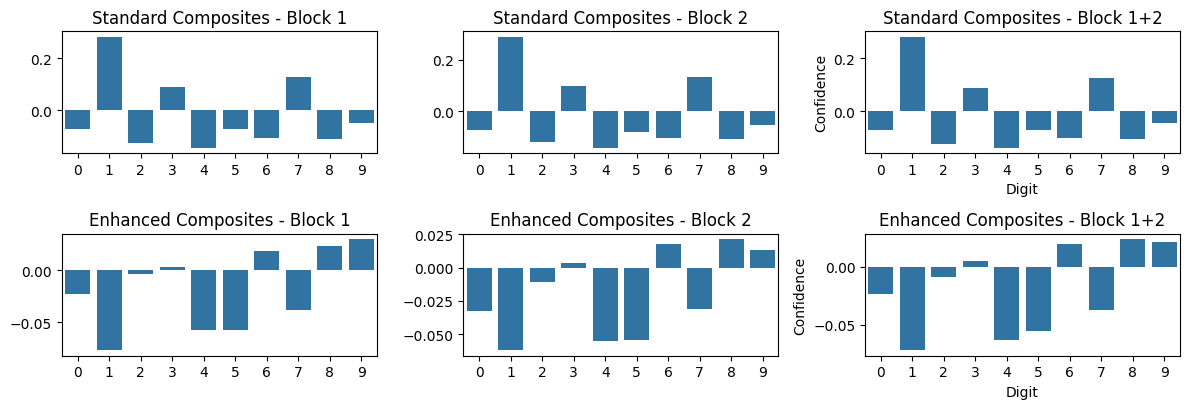


Participant 275555 - Main Target Digit: 6



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.2216,0.1703,2,nan,nan,2
1,Standard Composites,1,6,1,0.2776,-0.0957,7,0.9964,1.0000,5
2,Standard Composites,2,6,1,0.2815,-0.1021,7,0.9964,1.0000,5
3,Standard Composites,1+2,6,1,0.2673,-0.0942,7,nan,nan,5
4,Enhanced Composites,1,6,9,0.0258,0.0142,3,0.9964,1.0000,3
5,Enhanced Composites,2,6,9,0.0239,0.0096,3,0.9964,1.0000,3
6,Enhanced Composites,1+2,6,9,0.0237,0.0152,3,nan,nan,3



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: 1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: 1.0000
Digit 9: 1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: -1.0000
Digit 8: -1.0000
Digit 9: -1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


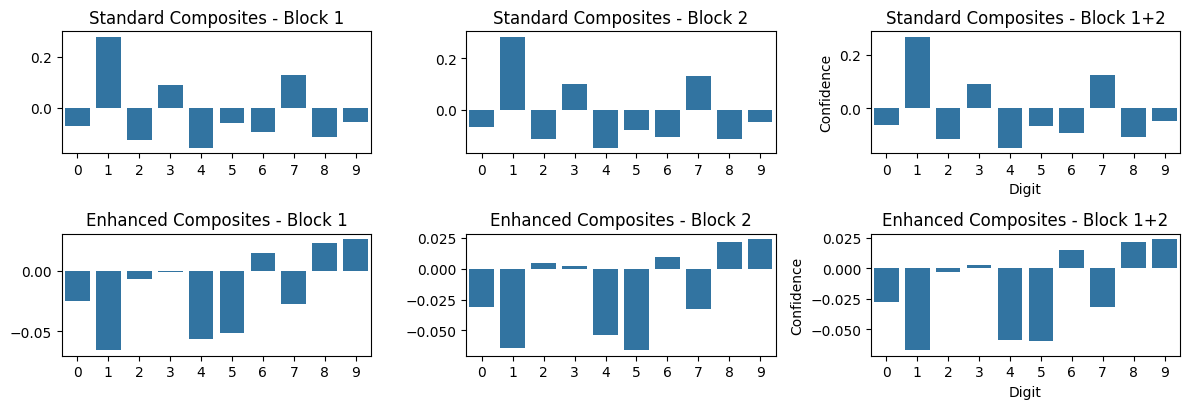


Participant tyl2g22 - Main Target Digit: 9



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.1984,0.1636,2,nan,nan,2
1,Standard Composites,1,9,1,0.2984,-0.0585,4,0.9971,1.0000,2
2,Standard Composites,2,9,1,0.2837,-0.0486,4,0.9971,1.0000,2
3,Standard Composites,1+2,9,1,0.2804,-0.0487,4,nan,nan,2
4,Enhanced Composites,1,9,8,0.0296,0.0181,3,0.9971,1.0000,1
5,Enhanced Composites,2,9,8,0.0260,0.0210,2,0.9971,1.0000,1
6,Enhanced Composites,1+2,9,8,0.0266,0.0200,3,nan,nan,1



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: 1.0000
Digit 1: -1.0000
Digit 2: 1.0000
Digit 3: -1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: -1.0000
Digit 8: 1.0000
Digit 9: 1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: -1.0000
Digit 2: -1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: 1.0000
Digit 6: -1.0000
Digit 7: -1.0000
Digit 8: -1.0000
Digit 9: 1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


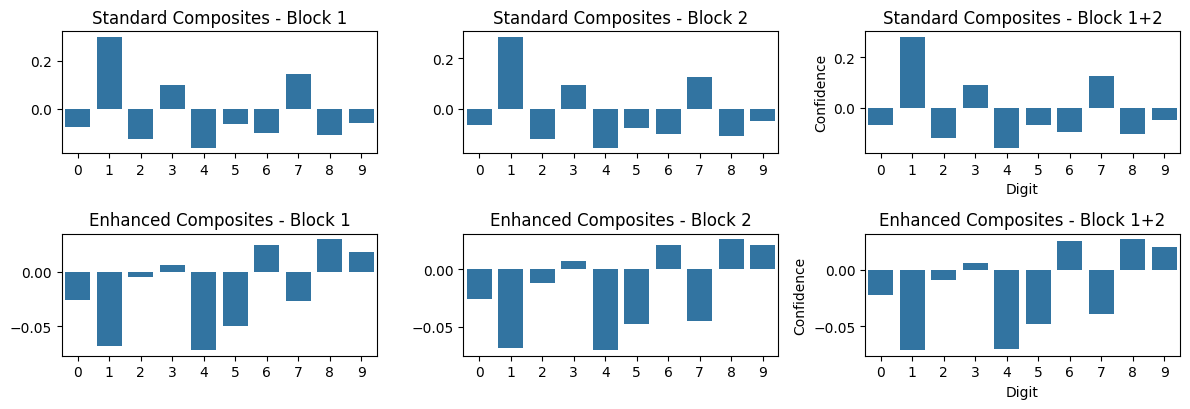


Participant ab8n22 - Main Target Digit: 6



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.2265,0.1679,2,nan,nan,2
1,Standard Composites,1,6,1,0.2839,-0.1002,7,0.9951,1.0000,5
2,Standard Composites,2,6,1,0.2864,-0.0861,7,0.9951,1.0000,5
3,Standard Composites,1+2,6,1,0.2724,-0.0870,7,nan,nan,5
4,Enhanced Composites,1,6,8,0.0243,0.0235,2,0.9951,1.0000,2
5,Enhanced Composites,2,6,8,0.0300,0.0235,2,0.9951,1.0000,2
6,Enhanced Composites,1+2,6,8,0.0274,0.0251,2,nan,nan,2



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: 1.0000
Digit 1: 1.0000
Digit 2: -1.0000
Digit 3: -1.0000
Digit 4: 1.0000
Digit 5: 1.0000
Digit 6: 1.0000
Digit 7: -1.0000
Digit 8: 1.0000
Digit 9: -1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: -1.0000
Digit 3: -1.0000
Digit 4: 1.0000
Digit 5: 1.0000
Digit 6: -1.0000
Digit 7: -1.0000
Digit 8: 1.0000
Digit 9: 1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


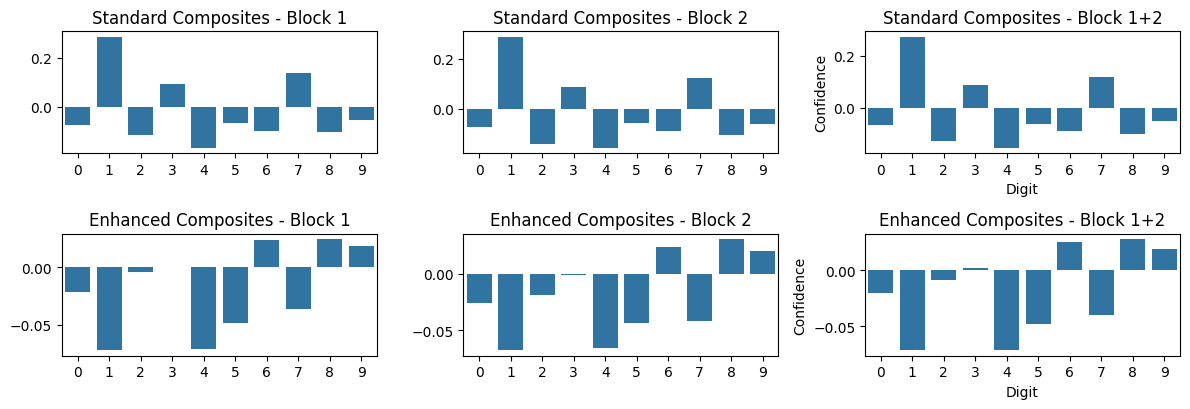


Participant 110424 - Main Target Digit: 9



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.2372,0.1746,2,nan,nan,2
1,Standard Composites,1,9,1,0.2718,-0.0492,4,0.9873,1.0000,2
2,Standard Composites,2,9,1,0.3069,-0.0547,4,0.9873,1.0000,2
3,Standard Composites,1+2,9,1,0.2729,-0.0469,4,nan,nan,2
4,Enhanced Composites,1,9,8,0.0303,0.0270,3,0.9873,1.0000,1
5,Enhanced Composites,2,9,8,0.0192,0.0191,2,0.9873,1.0000,1
6,Enhanced Composites,1+2,9,8,0.0272,0.0262,2,nan,nan,1



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: -1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: -1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


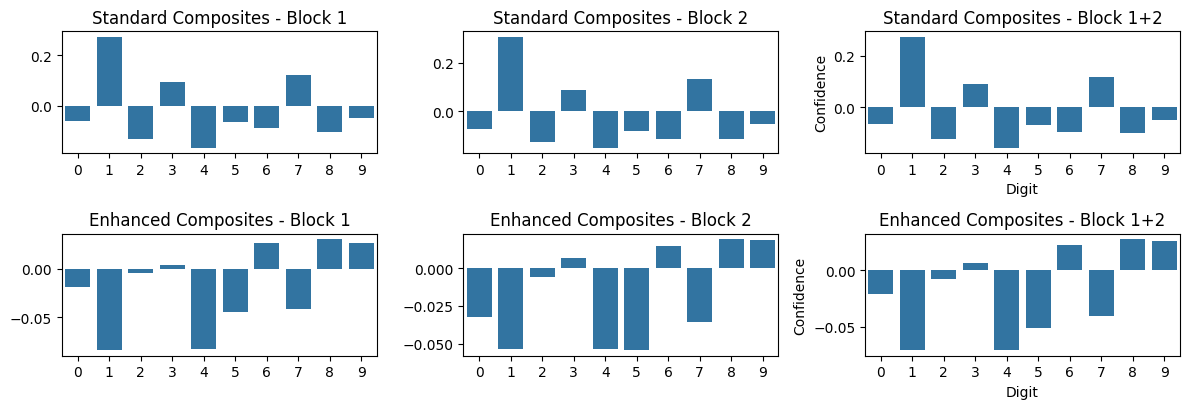


Participant jl18g24 - Main Target Digit: 9



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.2563,0.1200,2,nan,nan,2
1,Standard Composites,1,9,1,0.2922,-0.0514,4,0.9910,1.0000,2
2,Standard Composites,2,9,1,0.2934,-0.0641,4,0.9910,1.0000,2
3,Standard Composites,1+2,9,1,0.2861,-0.0478,4,nan,nan,2
4,Enhanced Composites,1,9,9,0.0385,0.0385,1,0.9910,1.0000,0
5,Enhanced Composites,2,9,8,0.0218,0.0040,4,0.9910,1.0000,1
6,Enhanced Composites,1+2,9,8,0.0229,0.0209,2,nan,nan,1



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


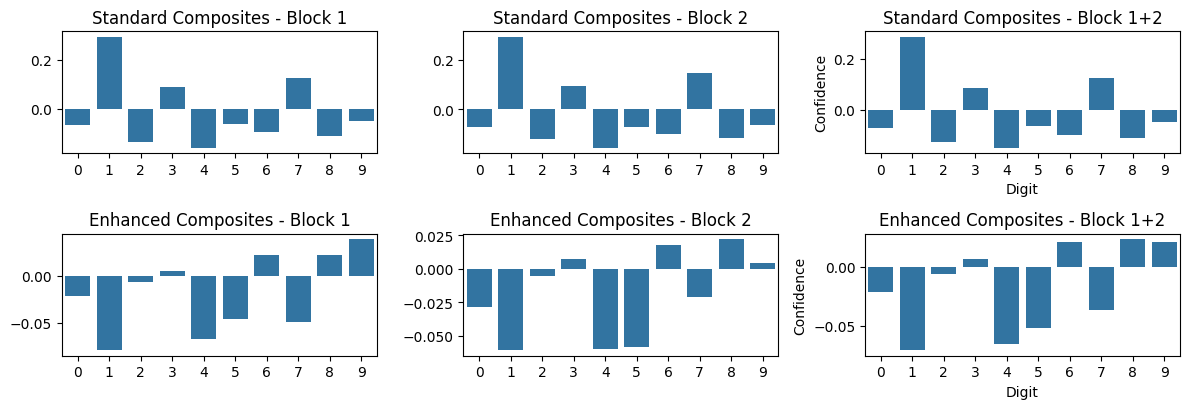


Participant 00000 - Main Target Digit: 6



,Composite Type,Block,Target,Predicted Digit,Confidence,Target Confidence,Target Rank,Test-Retest (All),Test-Retest (Target),Distance
0,Training,N/A,3,1,0.2380,0.1377,2,nan,nan,2
1,Standard Composites,1,6,1,0.2782,-0.0966,7,0.9902,1.0000,5
2,Standard Composites,2,6,1,0.2876,-0.1034,7,0.9902,1.0000,5
3,Standard Composites,1+2,6,1,0.2741,-0.0908,7,nan,nan,5
4,Enhanced Composites,1,6,9,0.0378,0.0314,3,0.9902,1.0000,3
5,Enhanced Composites,2,6,8,0.0277,0.0250,2,0.9902,1.0000,2
6,Enhanced Composites,1+2,6,6,0.0316,0.0316,1,nan,nan,0



Test-Retest Correlations for All Digits:

Standard Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: 1.0000
Digit 9: -1.0000

Enhanced Composites:
Digit 0: -1.0000
Digit 1: 1.0000
Digit 2: 1.0000
Digit 3: 1.0000
Digit 4: 1.0000
Digit 5: -1.0000
Digit 6: -1.0000
Digit 7: 1.0000
Digit 8: -1.0000
Digit 9: -1.0000


C:\Users\Sai\AppData\Local\Temp\ipykernel_7520\2343094976.py:134: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3*i + j + 1)


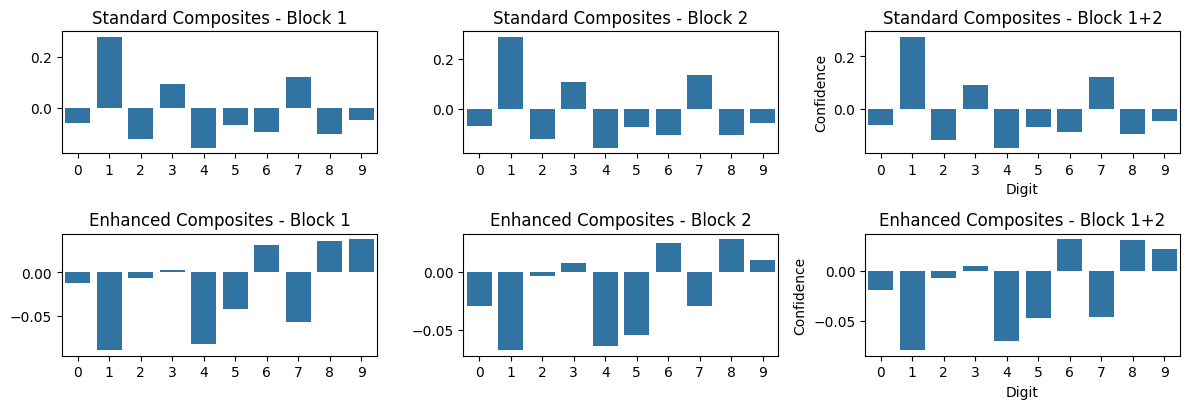

In [17]:
def pearson_correlation(x, y):
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length")
    if len(x) == 0 or len(y) == 0:
        return np.nan
    if len(set(x)) == 1 and len(set(y)) == 1:
        return 1.0  # Perfect correlation if both arrays are constant
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_diff, y_diff = x - x_mean, y - y_mean
    numerator = np.sum(x_diff * y_diff)
    denominator = np.sqrt(np.sum(x_diff**2) * np.sum(y_diff**2))
    if denominator == 0:
        return np.nan
    return numerator / denominator

def calculate_test_retest(predictions, target_digit):
    test_retest_results = {}
    
    for composite_type in ['standard_composites', 'enhanced_composites']:
        test_retest_results[composite_type] = {}
        for block in [1, 2]:
            block_predictions = predictions[composite_type][block]
            for digit in range(10):
                if digit not in test_retest_results[composite_type]:
                    test_retest_results[composite_type][digit] = []
                test_retest_results[composite_type][digit].append(block_predictions[digit])

    # Calculate correlations for each digit and composite type
    correlation_results = {}
    for composite_type, digit_data in test_retest_results.items():
        correlation_results[composite_type] = {}
        for digit, values in digit_data.items():
            correlation_results[composite_type][digit] = pearson_correlation(values, [1, 2])

    # Calculate overall test-retest for all digits
    all_block1 = []
    all_block2 = []
    for composite_type in ['standard_composites', 'enhanced_composites']:
        all_block1.extend(predictions[composite_type][1])
        all_block2.extend(predictions[composite_type][2])
    overall_correlation = pearson_correlation(all_block1, all_block2)

    # Calculate test-retest for target digit
    target_block1 = [predictions['standard_composites'][1][target_digit], 
                     predictions['enhanced_composites'][1][target_digit]]
    target_block2 = [predictions['standard_composites'][2][target_digit], 
                     predictions['enhanced_composites'][2][target_digit]]
    target_correlation = pearson_correlation(target_block1, target_block2)

    return {
        'all_digits': correlation_results,
        'overall': overall_correlation,
        'target': target_correlation
    }

# Now let's update the display_classification_results function to use this new calculation
def display_classification_results(classifications, all_participants_data):
    for participant_id, predictions in classifications.items():
        main_target_digit = all_participants_data[participant_id]['main_condition']
        training_target_digit = 3  # As you mentioned it's always 3 for the pilot
        
        print(f"\n{'='*50}")
        print(f"Participant {participant_id} - Main Target Digit: {main_target_digit}")
        print(f"{'='*50}\n")
        
        # Calculate test-retest reliability
        test_retest = calculate_test_retest(predictions, main_target_digit)
        
        # Create a DataFrame for all predictions
        df_data = []
        
        # Add training composite data
        df_data.append({
            'Composite Type': 'Training',
            'Block': 'N/A',
            'Target': training_target_digit,
            'Predicted Digit': np.argmax(predictions['training_composite']),
            'Confidence': np.max(predictions['training_composite']),
            'Target Confidence': predictions['training_composite'][training_target_digit],
            'Target Rank': get_target_rank(predictions['training_composite'], training_target_digit),
            'Test-Retest (All)': np.nan,
            'Test-Retest (Target)': np.nan
        })
        
        # Add standard and enhanced composite data
        for composite_type in ['standard_composites', 'enhanced_composites']:
            for block in [1, 2, '1+2']:
                pred = predictions[composite_type][block]
                df_data.append({
                    'Composite Type': composite_type.replace('_', ' ').title(),
                    'Block': block,
                    'Target': main_target_digit,
                    'Predicted Digit': np.argmax(pred),
                    'Confidence': np.max(pred),
                    'Target Confidence': pred[main_target_digit],
                    'Target Rank': get_target_rank(pred, main_target_digit),
                    'Test-Retest (All)': test_retest['overall'] if block in [1, 2] else np.nan,
                    'Test-Retest (Target)': test_retest['target'] if block in [1, 2] else np.nan
                })
        
        df = pd.DataFrame(df_data)
        df['Distance'] = df.apply(lambda row: min((row['Predicted Digit'] - row['Target']) % 10, (row['Target'] - row['Predicted Digit']) % 10), axis=1)
        
        # Style the DataFrame
        styled_df = df.style.background_gradient(subset=['Confidence', 'Target Confidence'], cmap='YlGnBu')\
                            .background_gradient(subset=['Distance'], cmap='RdYlGn_r')\
                            .background_gradient(subset=['Test-Retest (All)', 'Test-Retest (Target)'], cmap='YlGnBu')\
                            .format({
                                'Confidence': '{:.4f}',
                                'Target Confidence': '{:.4f}',
                                'Distance': '{:.0f}',
                                'Test-Retest (All)': '{:.4f}',
                                'Test-Retest (Target)': '{:.4f}'
                            })
        
        display(HTML(styled_df.to_html()))
        
        # Display test-retest correlations for all digits
        print("\nTest-Retest Correlations for All Digits:")
        for composite_type, digit_correlations in test_retest['all_digits'].items():
            print(f"\n{composite_type.replace('_', ' ').title()}:")
            for digit, corr in digit_correlations.items():
                print(f"Digit {digit}: {corr:.4f}")
        
        # Plot confidence distributions
        plt.figure(figsize=(12, 6))
        for i, composite_type in enumerate(['training_composite', 'standard_composites', 'enhanced_composites']):
            if composite_type == 'training_composite':
                plt.subplot(1, 3, i+1)
                sns.barplot(x=list(range(10)), y=predictions[composite_type])
                plt.title(f"Training Composite")
            else:
                for j, block in enumerate([1, 2, '1+2']):
                    plt.subplot(3, 3, 3*i + j + 1)
                    sns.barplot(x=list(range(10)), y=predictions[composite_type][block])
                    plt.title(f"{composite_type.replace('_', ' ').title()} - Block {block}")
            plt.xlabel("Digit")
            plt.ylabel("Confidence")
        plt.tight_layout()
        plt.show()

# Use this function to display the results
display_classification_results(classifications, all_participants_data)

In [ ]:
display_classification_results(classifications, all_participants_data)

that isn't test-retest but a comparison of confidence vectors which is indicative of overfitting to 1

lets make some quick plots